# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [267]:
import os
import json
import pandas as pd
import numpy as np
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

In [151]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [152]:
PATH_TO_DATA = "../data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [153]:
df_train_features.shape

(31698, 245)

In [154]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [155]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [156]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [157]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [158]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 30.6 s, sys: 62.5 ms, total: 30.6 s
Wall time: 4.86 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [159]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [160]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [161]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [162]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [163]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_18-13-59.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [164]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [166]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 8.36 s, sys: 675 ms, total: 9.04 s
Wall time: 31.8 s


In [167]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [168]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [169]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [170]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

In [171]:
match.keys()

dict_keys(['game_time', 'match_id_hash', 'teamfights', 'objectives', 'chat', 'game_mode', 'lobby_type', 'players', 'targets'])

In [172]:
player.keys()

dict_keys(['player_slot', 'hero_id', 'hero_name', 'account_id_hash', 'ability_upgrades', 'obs_placed', 'sen_placed', 'creeps_stacked', 'camps_stacked', 'rune_pickups', 'firstblood_claimed', 'teamfight_participation', 'towers_killed', 'roshans_killed', 'observers_placed', 'stuns', 'max_hero_hit', 'times', 'gold_t', 'lh_t', 'dn_t', 'xp_t', 'obs_log', 'sen_log', 'obs_left_log', 'sen_left_log', 'purchase_log', 'kills_log', 'buyback_log', 'runes_log', 'obs', 'sen', 'actions', 'pings', 'purchase', 'gold_reasons', 'xp_reasons', 'killed', 'item_uses', 'ability_uses', 'hero_hits', 'damage', 'damage_taken', 'damage_inflictor', 'runes', 'killed_by', 'kill_streaks', 'multi_kills', 'life_state', 'healing', 'damage_inflictor_received', 'randomed', 'pred_vict', 'gold', 'lh', 'xp', 'x', 'y', 'hero_inventory', 'hero_stash', 'health', 'max_health', 'max_mana', 'level', 'kills', 'deaths', 'assists', 'denies', 'nearby_creep_death_count'])

In [173]:
player['nearby_creep_death_count']

164

In [174]:
sum(list(player['ability_uses'].values()))

62

In [175]:
sum(list(player["purchase"].values()))

36

In [176]:
for ab in player.keys():
    print(ab)

player_slot
hero_id
hero_name
account_id_hash
ability_upgrades
obs_placed
sen_placed
creeps_stacked
camps_stacked
rune_pickups
firstblood_claimed
teamfight_participation
towers_killed
roshans_killed
observers_placed
stuns
max_hero_hit
times
gold_t
lh_t
dn_t
xp_t
obs_log
sen_log
obs_left_log
sen_left_log
purchase_log
kills_log
buyback_log
runes_log
obs
sen
actions
pings
purchase
gold_reasons
xp_reasons
killed
item_uses
ability_uses
hero_hits
damage
damage_taken
damage_inflictor
runes
killed_by
kill_streaks
multi_kills
life_state
healing
damage_inflictor_received
randomed
pred_vict
gold
lh
xp
x
y
hero_inventory
hero_stash
health
max_health
max_mana
level
kills
deaths
assists
denies
nearby_creep_death_count


KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [177]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

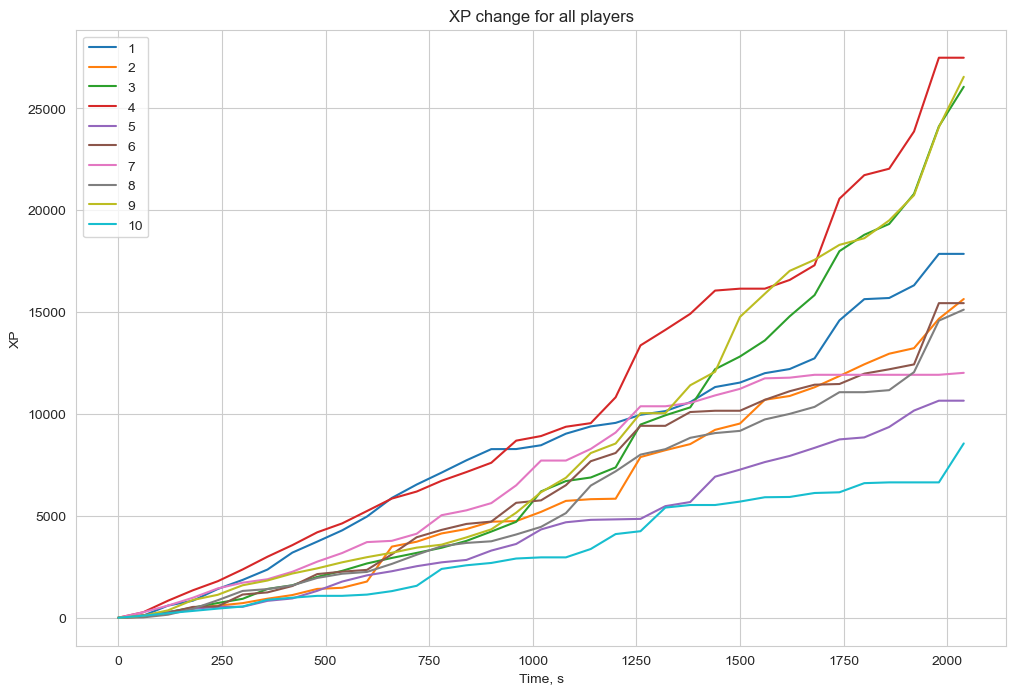

In [178]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [179]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

So, I supposed that the following features might be useful:
* ability_upgrades
* ability_uses
* purchases
* item_uses
* damage
* damage_taken 
* nearby_creep_death_count - gives gold
* pred_vict - actually I have no idea what thif feature stands for, I suppose that before the game players made bets on victory and assumed it to be an important feature

In [330]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills

        for player_id in range(10):
            player = match["players"][player_id]
            ability_upgr_n = len(player["ability_upgrades"])
            ability_uses_n = sum(list(player['ability_uses'].values()))
            purchase_n = sum(list(player["purchase"].values()))
            item_use_n = sum(list(player["item_uses"].values()))
            dmg = sum(list(player["damage"].values()))
            dmg_taken = sum(list(player["damage_taken"].values()))
            nearby_creep_death_count = player["nearby_creep_death_count"]
            pred_vict = player["pred_vict"]

            player_num = f"r{player_id + 1}" if player_id <= 4 else f"d{player_id - 4}"

            df_features.loc[match_id_hash, f"{player_num}_ability_upgrades"] = ability_upgr_n
            df_features.loc[match_id_hash, f"{player_num}_ability_uses"] = ability_uses_n
            df_features.loc[match_id_hash, f"{player_num}_purchases"] = purchase_n
            df_features.loc[match_id_hash, f"{player_num}_item_uses"] = item_use_n
            df_features.loc[match_id_hash, f"{player_num}_damage_given"] = dmg
            df_features.loc[match_id_hash, f"{player_num}_damage_taken"] = dmg_taken
            df_features.loc[match_id_hash, f"{player_num}_nearby_creep_death_count"] = nearby_creep_death_count
            df_features.loc[match_id_hash, f"{player_num}_pred_vict"] = pred_vict


            
            
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [376]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()
df_test_features_extended = df_test_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))
add_new_features(df_test_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "test_raw_data.jsonl"))

  0%|          | 0/31698 [00:00<?, ?it/s]

  0%|          | 0/31698 [00:00<?, ?it/s]

In [332]:
df_train_features_extended.to_csv("df_train_extended.tsv", sep="\t")
df_test_features_extended.to_csv("df_test_extended.tsv", sep="\t")

In [215]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d4_purchases,d4_item_uses,d4_damage_given,d4_damage_taken,d5_ability_upgrades,d5_ability_uses,d5_purchases,d5_item_uses,d5_damage_given,d5_damage_taken
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,24.0,15.0,7437.0,5893.0,4.0,7.0,12.0,9.0,2308.0,2154.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,5.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,10.0,1.0,1250.0,1040.0,0.0,2.0,9.0,2.0,4496.0,948.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,10.0,20.0,35511.0,9456.0,5.0,32.0,21.0,14.0,4682.0,1608.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,19.0,19.0,9070.0,2818.0,2.0,19.0,14.0,8.0,2156.0,1593.0


In [214]:
df_test_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d4_purchases,d4_item_uses,d4_damage_given,d4_damage_taken,d5_ability_upgrades,d5_ability_uses,d5_purchases,d5_item_uses,d5_damage_given,d5_damage_taken
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,9.0,4.0,868.0,16.0,0.0,4.0,6.0,3.0,2332.0,681.0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,19.0,7.0,6010.0,4201.0,3.0,19.0,13.0,11.0,3955.0,3317.0
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,9.0,7.0,8388.0,3160.0,2.0,9.0,7.0,6.0,10739.0,2785.0
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,19.0,13.0,5053.0,3237.0,7.0,7.0,14.0,10.0,15255.0,5052.0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,15.0,16.0,21681.0,3230.0,5.0,64.0,23.0,11.0,16086.0,5782.0


In [ ]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 103 ms, sys: 228 ms, total: 331 ms
Wall time: 58.6 s


In [ ]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778629346381704


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

## EDA

Количество игр в зависимости от времени игры распределено неравномерно, возможно, это связано с тем, что игры заканчиваются в разное время, и длинных игра не так много.

''

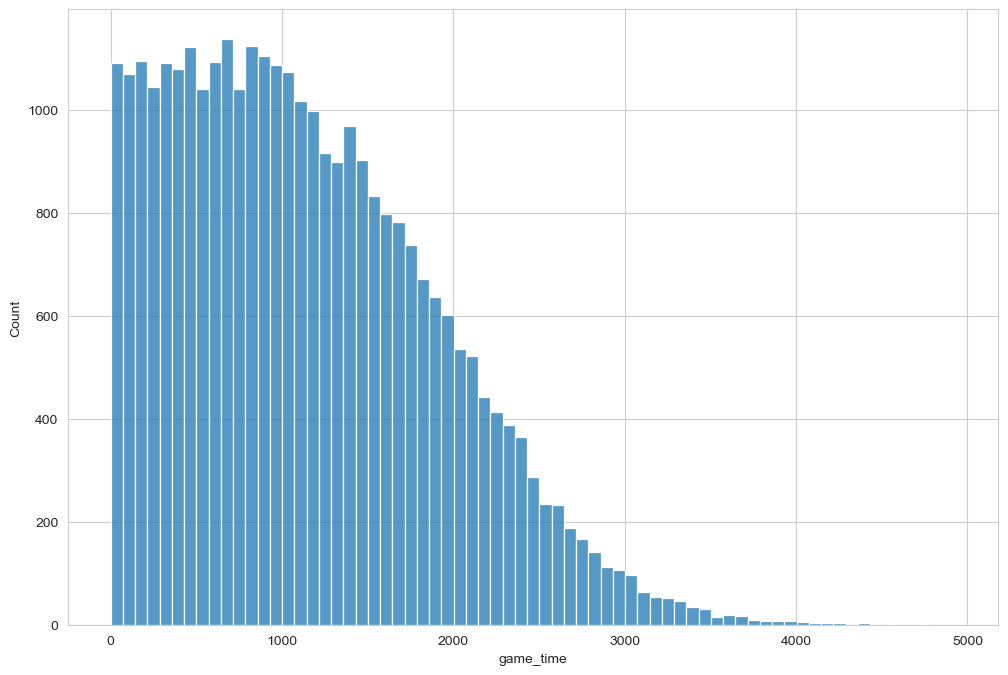

In [ ]:
sns.histplot(df_train_features, x="game_time")
;

''

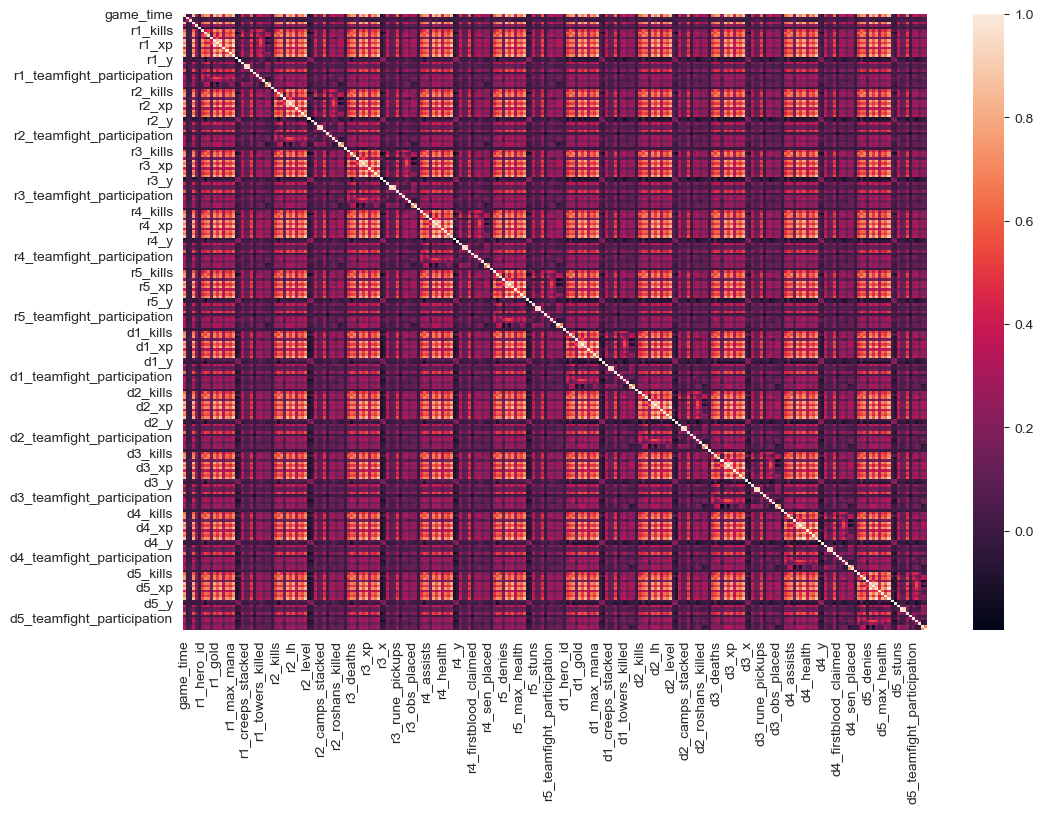

In [ ]:
sns.heatmap(df_train_features.corr())
;

Посмотрим на корреляции признаков для одного игрока, видим, что некоторые из них довольно сильно коррелируют

<AxesSubplot: >

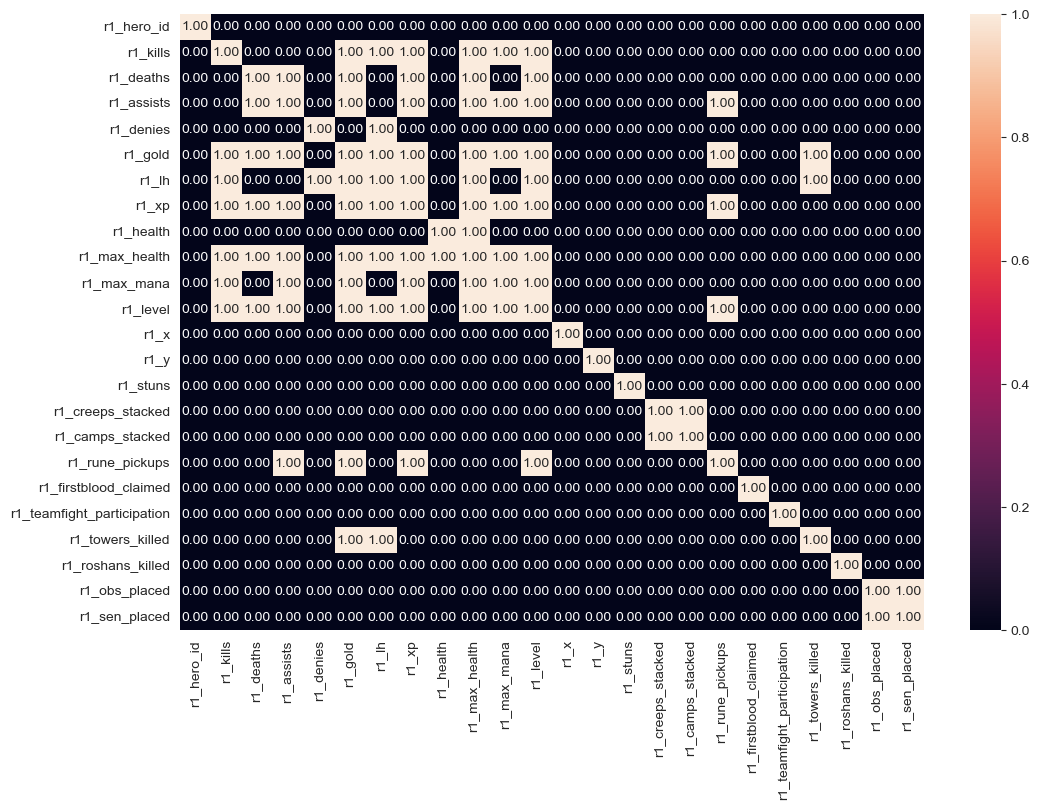

In [ ]:
r1_ftrs_lst = [ftr for ftr in df_train_features.columns if ftr.startswith("r1")]
sns.heatmap(df_train_features[r1_ftrs_lst].corr() > 0.5, annot=True, fmt=".2f")

Если наложить для всех 10 игроков корреляции признаков друг на друга, то будет виден определенный паттерн, эти признаки надо будет как-то объединить\трансформировать.

In [ ]:
list(df_train_features_extended.columns)

['game_time',
 'game_mode',
 'lobby_type',
 'objectives_len',
 'chat_len',
 'r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed',
 'r2_hero_id',
 'r2_kills',
 'r2_deaths',
 'r2_assists',
 'r2_denies',
 'r2_gold',
 'r2_lh',
 'r2_xp',
 'r2_health',
 'r2_max_health',
 'r2_max_mana',
 'r2_level',
 'r2_x',
 'r2_y',
 'r2_stuns',
 'r2_creeps_stacked',
 'r2_camps_stacked',
 'r2_rune_pickups',
 'r2_firstblood_claimed',
 'r2_teamfight_participation',
 'r2_towers_killed',
 'r2_roshans_killed',
 'r2_obs_placed',
 'r2_sen_placed',
 'r3_hero_id',
 'r3_kills',
 'r3_deaths',
 'r3_assists',
 'r3_denies',
 'r3_gold',
 'r3_lh',
 'r3_xp',
 'r3_health',
 'r3_max_health',
 '

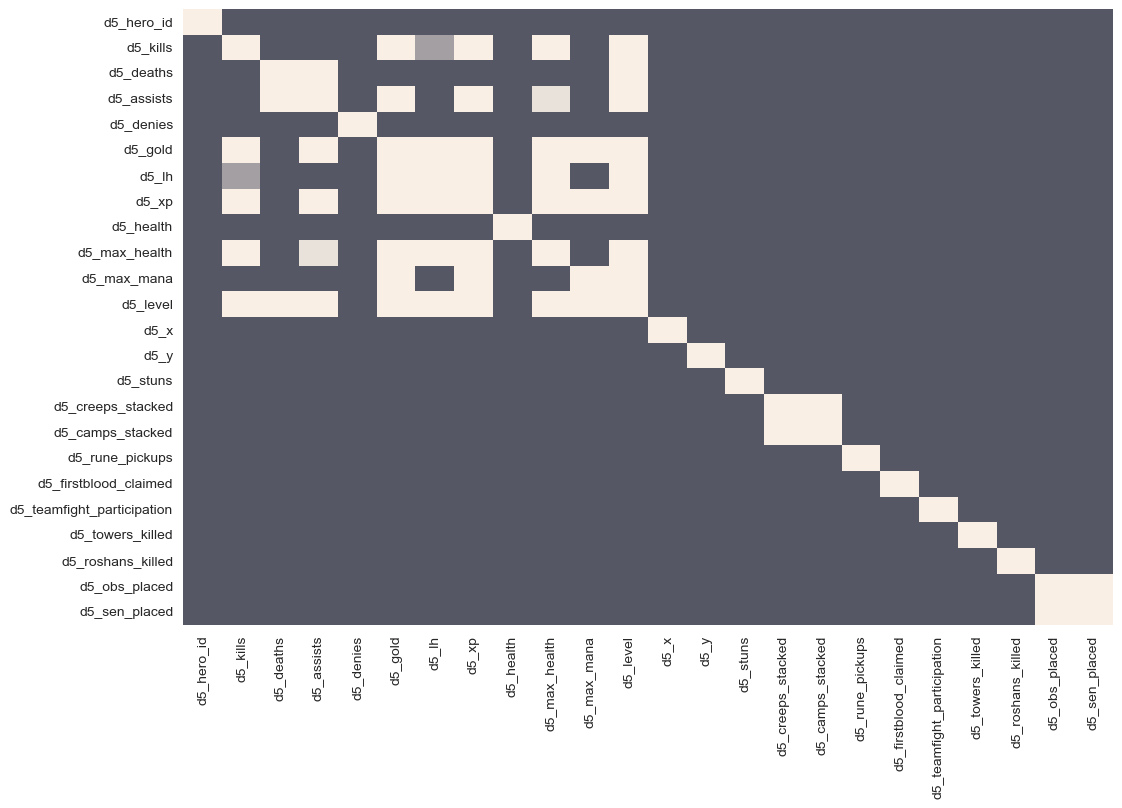

In [ ]:
for cmnd in ["r", "d"]:
    for plr in range(1, 6):
        plr_id = f"{cmnd}{plr}"
        plr_ftrs_lst = [ftr for ftr in df_train_features.columns if ftr.startswith(plr_id)]
        sns.heatmap(df_train_features[plr_ftrs_lst].corr() > 0.6, alpha=0.1, cbar=False)


<AxesSubplot: xlabel='d5_deaths', ylabel='d5_assists'>

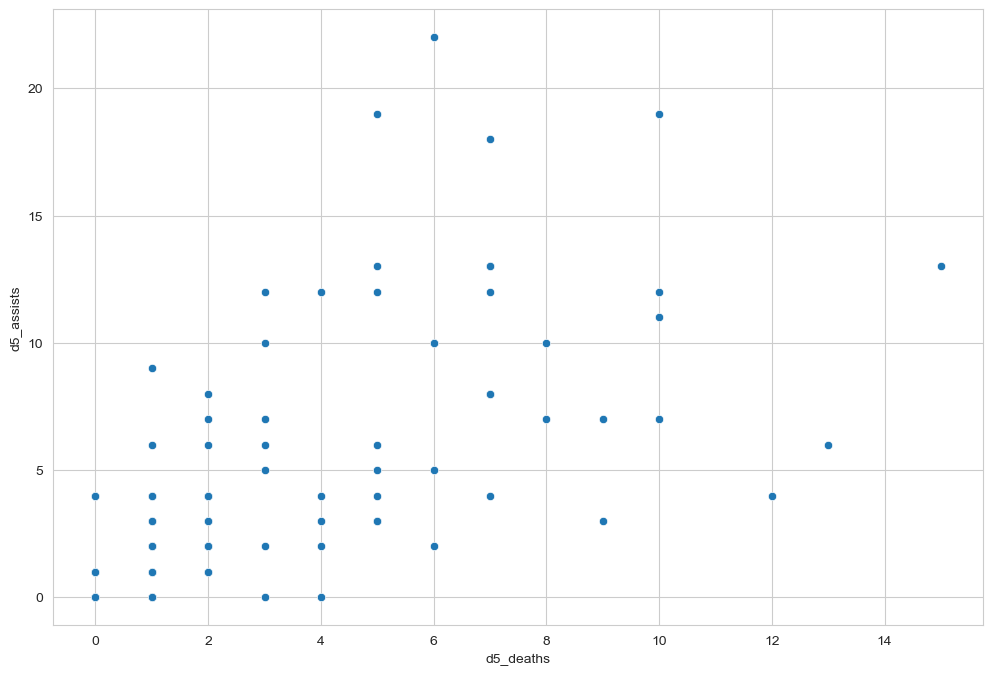

In [ ]:
sns.scatterplot(df_train_features[["d5_deaths", "d5_assists"]][1:100], x="d5_deaths", y="d5_assists")

In [212]:
PATH_TO_DATA = "../data"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [ ]:
%%time 
# base model
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513
CPU times: user 7.28 s, sys: 510 ms, total: 7.79 s
Wall time: 31.8 s


### Now I will transform some of the features of basic dataset and try to apply some models to it

Ввожу KDA + преобразую first_blood_claim в категориальную переменную для команды, тк он может случиться один раз за игру, 1 для radiant, 0 для dire.

In [ ]:
for team in ["r", "d"]:
    for player in range(1, 6):
        df_train_features[f"{team}{player}_kda"] = (df_train_features[f"{team}{player}_kills"] + df_train_features[f"{team}{player}_assists"]) / (df_train_features[f"{team}{player}_deaths"] + 1)
drop_list = []
for team in ["r", "d"]:
    for player in range(1, 6):
        drop_list.append(f"{team}{player}_kills")
        drop_list.append(f"{team}{player}_assists")
        drop_list.append(f"{team}{player}_deaths")
df_train_features = df_train_features.drop(drop_list, axis=1)

rad_first_blood_features_list = ["r1_firstblood_claimed", "r2_firstblood_claimed", "r3_firstblood_claimed", "r4_firstblood_claimed", "r5_firstblood_claimed"]
dire_first_blood_features_list = ["d1_firstblood_claimed", "d2_firstblood_claimed", "d3_firstblood_claimed", "d4_firstblood_claimed", "d5_firstblood_claimed"]
df_train_features["first_blood_claimed_radiant"] = df_train_features[rad_first_blood_features_list].sum(axis=1)
df_train_features = df_train_features.drop(rad_first_blood_features_list + dire_first_blood_features_list, axis=1)

In [ ]:
for team in ["r", "d"]:
    for player in range(1, 6):
        df_test_features[f"{team}{player}_kda"] = (df_test_features[f"{team}{player}_kills"] + df_test_features[f"{team}{player}_assists"]) / (df_test_features[f"{team}{player}_deaths"] + 1)
drop_list = []
for team in ["r", "d"]:
    for player in range(1, 6):
        drop_list.append(f"{team}{player}_kills")
        drop_list.append(f"{team}{player}_assists")
        drop_list.append(f"{team}{player}_deaths")
df_test_features = df_test_features.drop(drop_list, axis=1)

rad_first_blood_features_list = ["r1_firstblood_claimed", "r2_firstblood_claimed", "r3_firstblood_claimed", "r4_firstblood_claimed", "r5_firstblood_claimed"]
dire_first_blood_features_list = ["d1_firstblood_claimed", "d2_firstblood_claimed", "d3_firstblood_claimed", "d4_firstblood_claimed", "d5_firstblood_claimed"]
df_test_features["first_blood_claimed_radiant"] = df_test_features[rad_first_blood_features_list].sum(axis=1)
df_test_features = df_test_features.drop(rad_first_blood_features_list + dire_first_blood_features_list, axis=1)

In [ ]:
%%time
# kda and first blood claim by team
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7776936265657336
CPU times: user 7.66 s, sys: 561 ms, total: 8.22 s
Wall time: 25.3 s


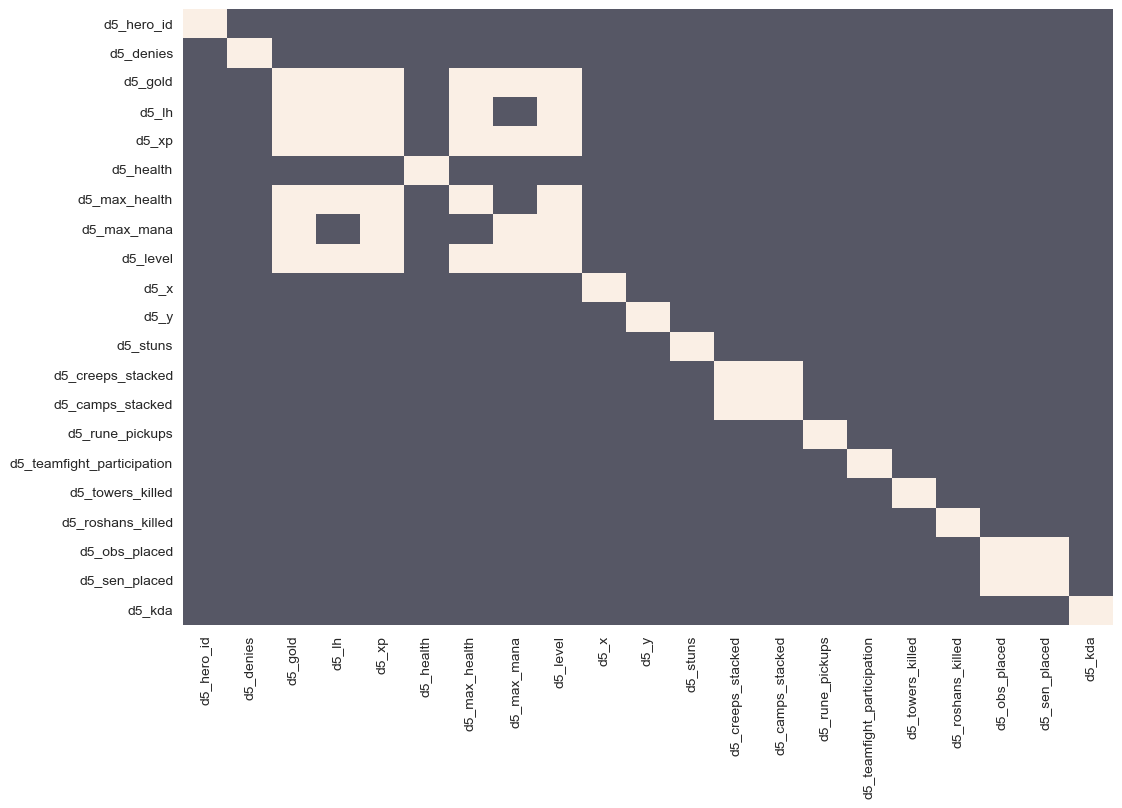

In [ ]:
for cmnd in ["r", "d"]:
    for plr in range(1, 6):
        plr_id = f"{cmnd}{plr}"
        plr_ftrs_lst = [ftr for ftr in df_train_features.columns if ftr.startswith(plr_id)]
        sns.heatmap(df_train_features[plr_ftrs_lst].corr() > 0.6, alpha=0.1, cbar=False)


<AxesSubplot: >

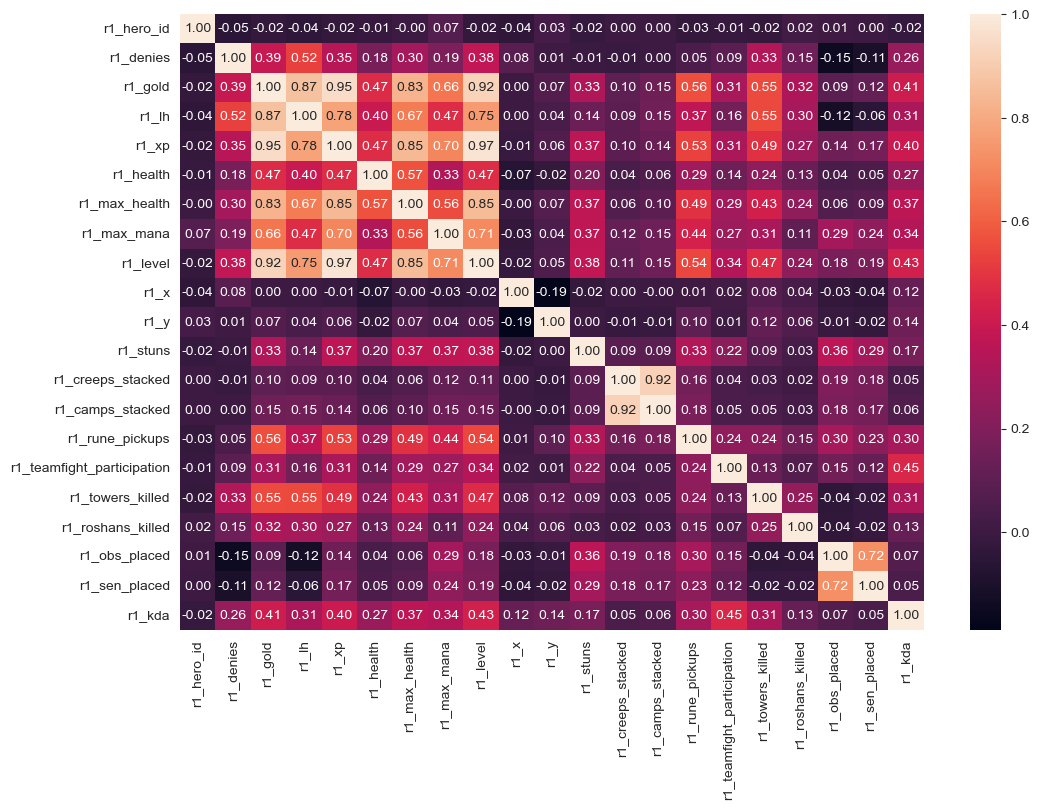

In [ ]:
r1_ftrs_lst = [ftr for ftr in df_train_features.columns if ftr.startswith("r1")]
sns.heatmap(df_train_features[r1_ftrs_lst].corr(), annot=True, fmt=".2f")

In [ ]:
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)
X_test = df_test_features.values
rf_model
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-05_23-17-55.csv


OKay, let's try to sum up hero features per team; same features within different heroes do not corralste, but I will calculate their sums or meand to evaluate the team score

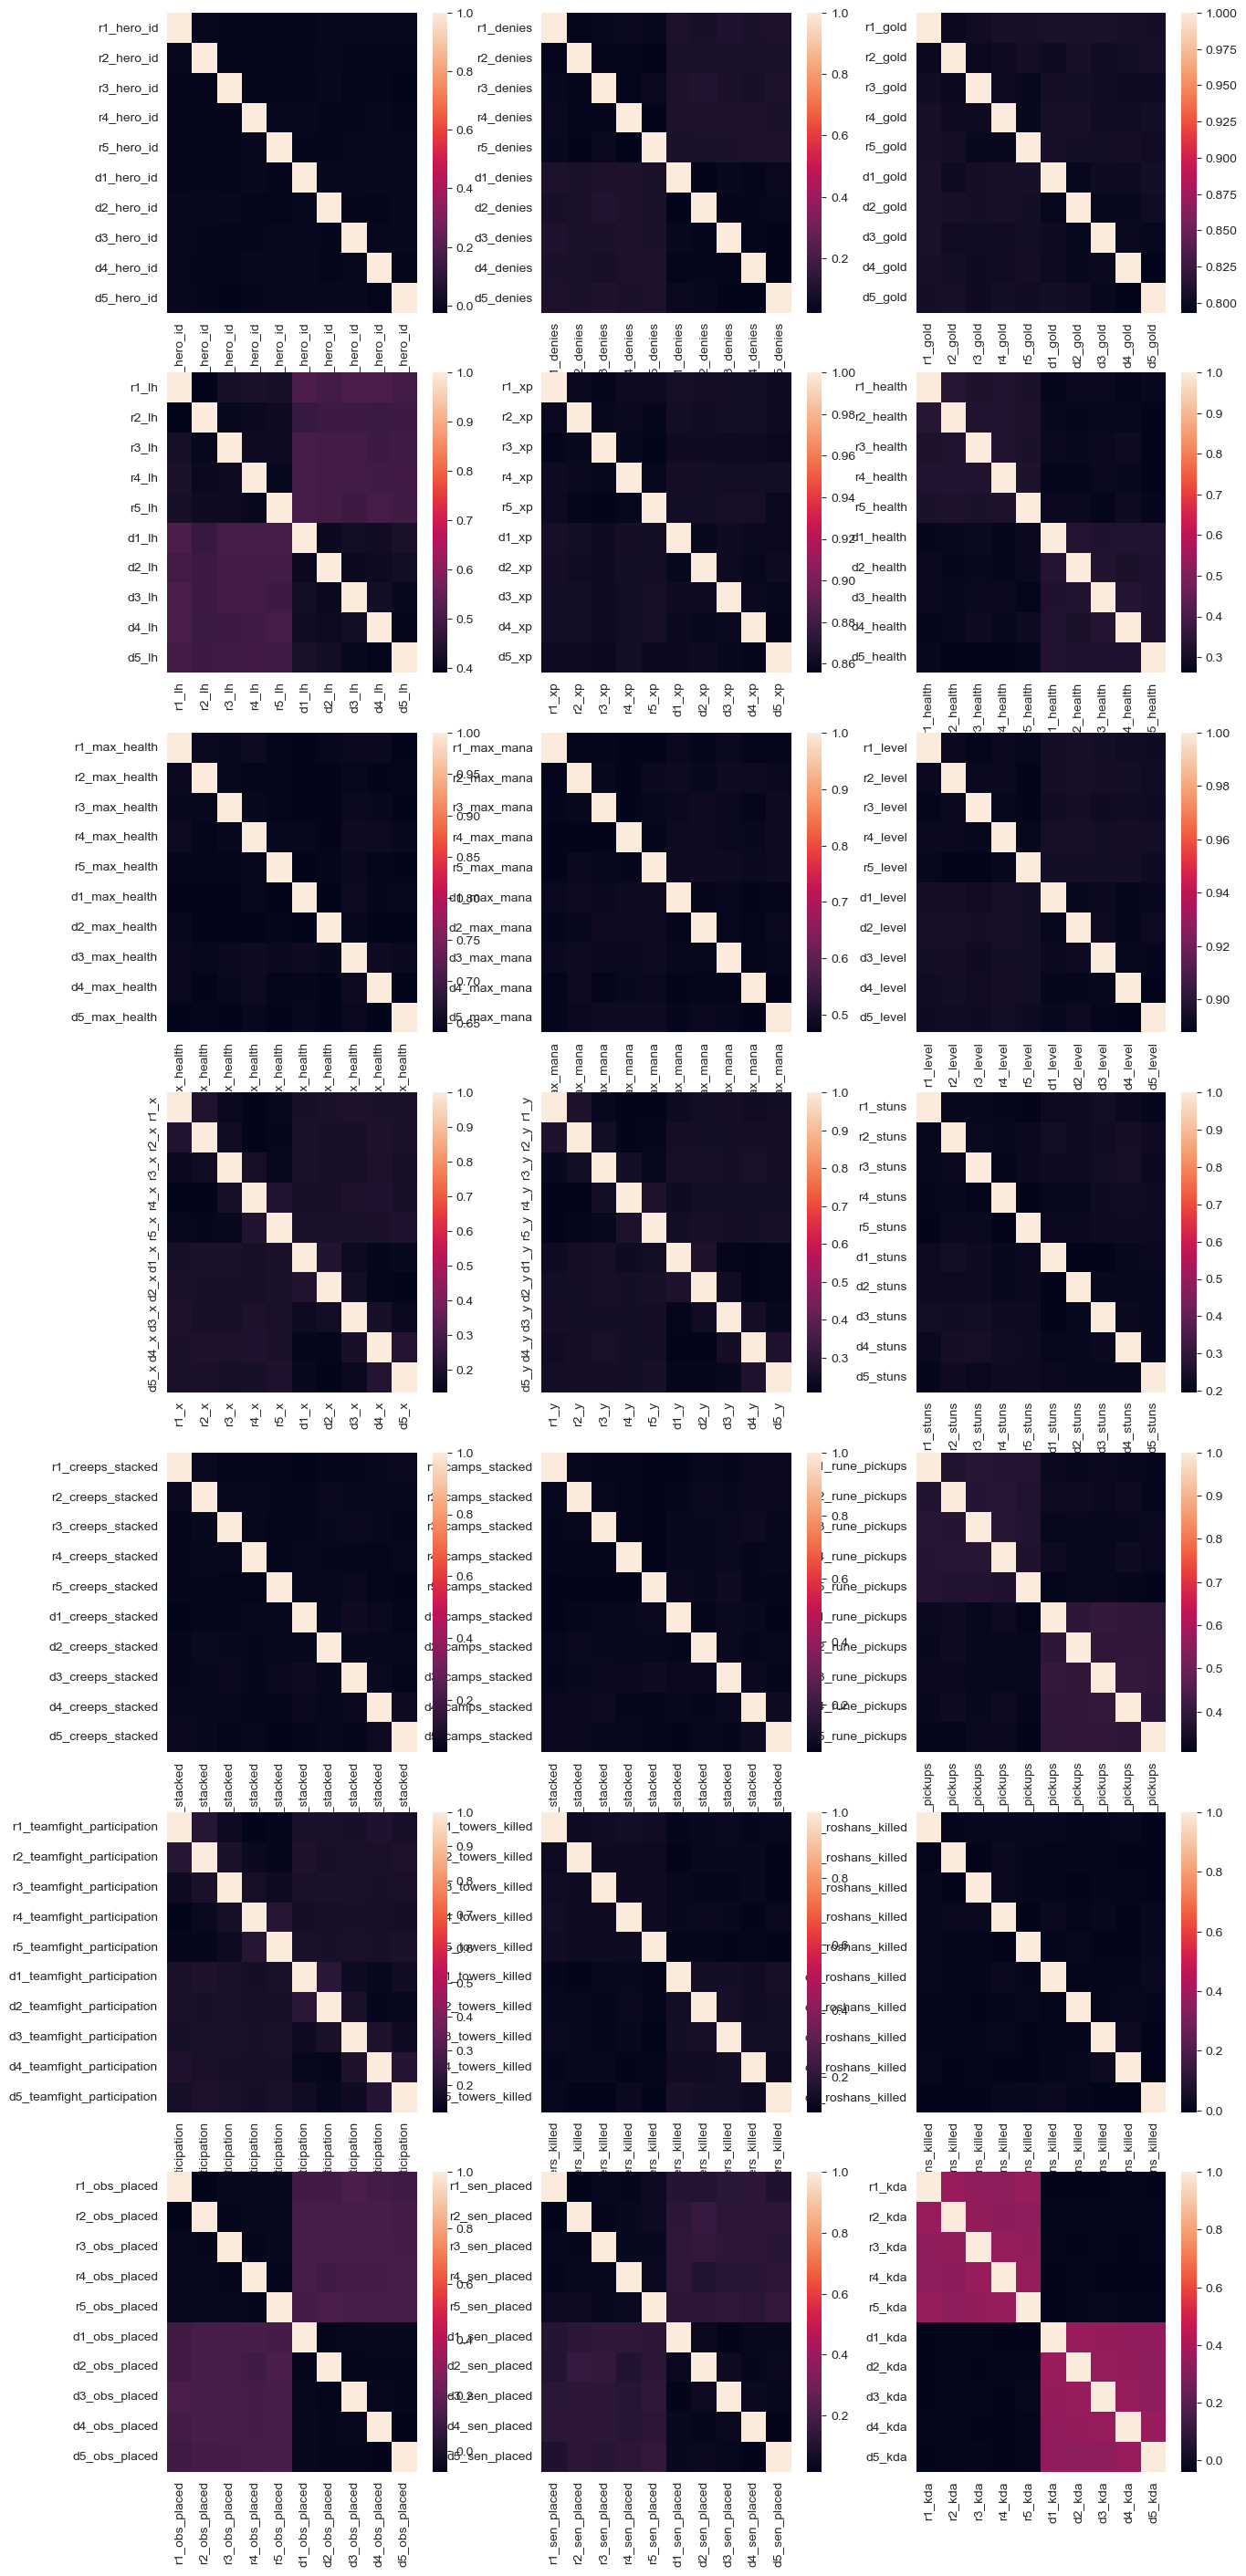

In [ ]:
plr_ftrs_lst = [ftr[3:] for ftr in df_train_features.columns if ftr.startswith("r1")]
fig, axes = plt.subplots(7, 3, figsize=(15, 35))
axes = axes.ravel()
for feature, axis in enumerate(axes):
    r_feature = [f"r{plr}_{plr_ftrs_lst[feature]}" for plr in range(1, 6)]
    d_feature = [f"d{plr}_{plr_ftrs_lst[feature]}" for plr in range(1, 6)]
    sns.heatmap(df_train_features[r_feature + d_feature].corr(), ax=axis)

Best Random Forest (actually overfit, but I'll deal with it later, now I apply it only to understand whether my feature transformations are good or not)

In [ ]:
%%time
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=700, max_depth=19, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.787386574335213
CPU times: user 22.8 s, sys: 1.68 s, total: 24.5 s
Wall time: 2min 3s


best model yet

In [ ]:
rf_model = RandomForestClassifier(n_estimators=700, max_depth=19, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)
X_test = df_test_features.values
rf_model
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-06_00-11-19.csv


### For each hero calculate proportion wins/games and apply it instead of just hero id ###
This will range hero id to a more applicable parameter

In [ ]:
plrs = []
for tm in ["r", "d"]:
    for plr in range(1, 6):
        plrs.append(f"{tm}{plr}_hero_id")
plrs.append("radiant_win")

heroes_df = pd.concat([df_train_features, df_train_targets], axis=1)[plrs]

plrs.remove("radiant_win")

df_hero_count = pd.DataFrame(heroes_df.r1_hero_id.value_counts())\
    .reset_index()\
    .rename(columns={"index": "hero_id", "r1_hero_id": "games_total"})

for plr in plrs[1:]:
    intermed_df = pd.DataFrame(heroes_df[plr].value_counts())\
    .reset_index()\
    .rename(columns={"index": "hero_id", str(plr): "games_total"})
    df_hero_count = pd.merge(df_hero_count, intermed_df, on="hero_id")
df_hero_count["games_total"] = df_hero_count.drop("hero_id", axis=1).sum(axis=1)    
df_hero_count = df_hero_count[["hero_id", "games_total"]]
df_hero_count.head()    

,hero_id,games_total
0,14,13207
1,11,9187
2,32,7628
3,8,7270
4,74,6392


In [ ]:
rad_win = heroes_df[heroes_df.radiant_win == True][['r1_hero_id', 'r2_hero_id', 'r3_hero_id', 'r4_hero_id', 'r5_hero_id']]
dire_win = heroes_df[heroes_df.radiant_win == False][['d1_hero_id', 'd2_hero_id', 'd3_hero_id', 'd4_hero_id', 'd5_hero_id']]
rad_win = rad_win.rename(columns={'r1_hero_id': "hero_1", 'r2_hero_id': "hero_2", 'r3_hero_id': "hero_3", 'r4_hero_id': "hero_4", 'r5_hero_id': "hero_5"})
dire_win = dire_win.rename(columns={'d1_hero_id': "hero_1", 'd2_hero_id': "hero_2", 'd3_hero_id': "hero_3", 'd4_hero_id': "hero_4", 'd5_hero_id': "hero_5"})
hero_win_df = pd.concat([rad_win, dire_win], axis=0)
hero_win_df.head()

,hero_1,hero_2,hero_3,hero_4,hero_5
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,15,96,27,63,89
6db558535151ea18ca70a6892197db41,101,51,44,49,53
c96d629dc0c39f0c616d1949938a6ba6,119,71,44,35,108
a3c3892648b873bb869dd81ca0f62286,8,91,32,12,69
5feece770ca79e5e8cd8052198b3f533,103,86,23,29,8


In [ ]:
df_win_count = pd.DataFrame(hero_win_df.hero_1.value_counts())\
    .reset_index()\
    .rename(columns={"index": "hero_id", "hero_1": "wins"})

for plr in range(2, 6):
    intermed_df = pd.DataFrame(hero_win_df[f"hero_{plr}"].value_counts())\
    .reset_index()\
    .rename(columns={"index": "hero_id", f"hero_{plr}": "wins"})
    df_win_count = pd.merge(df_win_count, intermed_df, on="hero_id")

df_win_count["win_count"] = df_win_count.drop("hero_id", axis=1).sum(axis=1)
df_win_count = df_win_count[["hero_id", "win_count"]]
df_win_count.head()

,hero_id,win_count
0,14,6659
1,11,4352
2,32,4415
3,8,3788
4,35,2857


In [ ]:
df_games_wins = pd.merge(df_hero_count, df_win_count, on="hero_id")
df_games_wins["win_prop"] = df_games_wins.win_count / df_games_wins.games_total
df_games_wins = df_games_wins.sort_values("hero_id")
win_proportion_dict = dict(zip(df_games_wins.hero_id, df_games_wins.win_prop))
df_games_wins.head()

,hero_id,games_total,win_count,win_prop
46,1,3020,1428,0.472848
30,2,3187,1601,0.502353
76,3,1754,896,0.510832
56,4,2290,1166,0.509170
8,5,5272,2734,0.518589


In [ ]:
for plr in plrs:
    df_train_features[plr] = df_train_features[plr].apply(lambda x: win_proportion_dict[x])
    df_test_features[plr] = df_test_features[plr].apply(lambda x: win_proportion_dict[x])

In [ ]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,first_blood_claimed_radiant
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.479358,7,5257,52,3937,...,2.500000,2.5,7.0,6.000000,0.333333,0.142857,0.500000,0.5,0.000000,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.522029,0,176,0,0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.532962,1,403,0,359,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.503966,5,3085,1,2828,...,1.333333,1.0,2.0,1.333333,0.800000,4.000000,2.333333,1.5,1.500000,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.505334,9,3516,40,3964,...,0.428571,2.0,0.5,0.000000,3.000000,0.666667,5.000000,1.0,1.666667,0


In [ ]:
df_test_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,first_blood_claimed_radiant
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,0.473713,0,543,7,533,...,0.0,0.000000,0.0,0.000000,1.000000,0.00,0.0,1.000000,0.000000,0
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,0.504202,1,1613,0,1471,...,2.0,2.000000,1.5,1.000000,0.000000,0.25,0.5,0.000000,0.000000,1
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,0.545796,0,1404,9,1351,...,1.0,0.000000,2.0,0.333333,1.000000,1.00,1.0,1.000000,0.500000,1
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,0.504766,3,2306,6,3088,...,1.0,0.333333,1.5,1.000000,1.166667,2.00,2.0,5.000000,0.333333,0
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,0.521045,8,3917,46,5081,...,1.0,1.500000,2.5,1.000000,0.000000,0.50,0.0,0.666667,0.750000,1


### Now x and y I want to encode as distance from Ancient. ###

Originally Ancients are placed at the coordinates (284, 5200) and (5200, 284), but here we have other min and max x and y values. I will suppose that (min(x), min(y)) and (max(x), max(y)) are the coordinates of Ancients.

Ancient radiant: (66, 70); Ancient dire: (188, 186).

Euclidean distance is used.

In [ ]:
df_train_features

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,first_blood_claimed_radiant
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0.479358,7,5257,52,3937,...,2.500000,2.500000,7.000000,6.000000,0.333333,0.142857,0.500000,0.500000,0.000000,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0.522029,0,176,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0.532962,1,403,0,359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,0.503966,5,3085,1,2828,...,1.333333,1.000000,2.000000,1.333333,0.800000,4.000000,2.333333,1.500000,1.500000,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0.505334,9,3516,40,3964,...,0.428571,2.000000,0.500000,0.000000,3.000000,0.666667,5.000000,1.000000,1.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,0.530687,3,19850,251,25448,...,1.818182,1.666667,2.857143,2.428571,1.352941,3.444444,13.000000,4.666667,3.200000,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,0.572719,3,13914,151,19592,...,1.571429,5.000000,15.000000,2.500000,1.750000,1.142857,1.200000,0.250000,0.625000,0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,0.472848,0,4613,59,4478,...,0.600000,0.428571,1.000000,1.250000,8.000000,5.000000,3.333333,2.400000,5.000000,0


In [ ]:
plrs_x = []
plrs_y = []
for tm in ["r", "d"]:
    for plr in range(1, 6):
        plrs_x.append(f"{tm}{plr}_x")
        plrs_y.append(f"{tm}{plr}_y")
x_min = min(df_train_features[plrs_x].min())
y_min = min(df_train_features[plrs_y].min())
x_max = max(df_train_features[plrs_x].max())
y_max = max(df_train_features[plrs_y].max())
print(f"Coordinates of the Ancient: ({x_min}, {y_min}); ({x_max}, {y_max}).")

Coordinates of the Ancient: (66, 70); (188, 186).


In [ ]:
ancient_coord = (x_min, y_min)
plrs = []
for tm in ["r", "d"]:
    for plr in range(1, 6):
        plrs.append(f"{tm}{plr}")

In [ ]:
def dists(x1, y1, x2, y2):
    return np.sqrt((np.square(x2 - x1) + np.square(y2 - y1)))

def distance_to_ancient(df, x2, y2):
    for plr in plrs:
        x1 = df[f"{plr}_x"]
        y1 = df[f"{plr}_y"]
        df[f"{plr}_dist_to_anc"] = dists(x1, y1, x2, y2)
    drop_lst = [f"{i}_x" for i in plrs] + [f"{i}_y" for i in plrs]
    df = df.drop(drop_lst, axis=1)
    return df

In [ ]:
df_train_features = distance_to_ancient(df_train_features, ancient_coord[0], ancient_coord[1])
df_test_features = distance_to_ancient(df_test_features, ancient_coord[0], ancient_coord[1])

In [ ]:
def mean_ftrs_by_plr(df, ftr):
    r_ftr_lst = [f"r{plr}_{ftr}" for plr in range(1, 6)]
    d_ftr_lst = [f"d{plr}_{ftr}" for plr in range(1, 6)]
    df[f'r_{ftr}'] = df[r_ftr_lst].mean(axis=1)
    df[f'd_{ftr}'] = df[d_ftr_lst].mean(axis=1)
    df = df.drop(r_ftr_lst + d_ftr_lst, axis=1)
    return (df)

def sum_up_ftrs_by_plr(df, ftr):
    r_ftr_lst = [f"r{plr}_{ftr}" for plr in range(1, 6)]
    d_ftr_lst = [f"d{plr}_{ftr}" for plr in range(1, 6)]
    df[f'r_{ftr}'] = df[r_ftr_lst].sum(axis=1)
    df[f'd_{ftr}'] = df[d_ftr_lst].sum(axis=1)
    df = df.drop(r_ftr_lst + d_ftr_lst, axis=1)
    return (df)

Hero ids will be counted as a asum as well because now they have values of hero success and refer to the team.

In [ ]:
plr_ftrs_lst = [ftr[3:] for ftr in df_train_features.columns if ftr.startswith("r1")]

for feature in plr_ftrs_lst:
    df_train_features = sum_up_ftrs_by_plr(df=df_train_features, ftr=feature)
    df_test_features = sum_up_ftrs_by_plr(df=df_test_features, ftr=feature)

In [ ]:
%%time
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=700, max_depth=19, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.819087237079156
CPU times: user 15.4 s, sys: 1.05 s, total: 16.5 s
Wall time: 1min 10s


Gold proportion to evaluate gold disbalance between two teams

In [ ]:
df_train_features["r_gold_prop"] = df_train_features.r_gold / (df_train_features.r_gold + df_train_features.d_gold)
df_test_features["r_gold_prop"] = df_test_features.r_gold / (df_test_features.r_gold + df_test_features.d_gold)
df_train_features = df_train_features.drop(["r_gold", "d_gold"], axis=1)
df_test_features = df_test_features.drop(["r_gold", "d_gold"], axis=1)

Lots of features correlate with game time

''

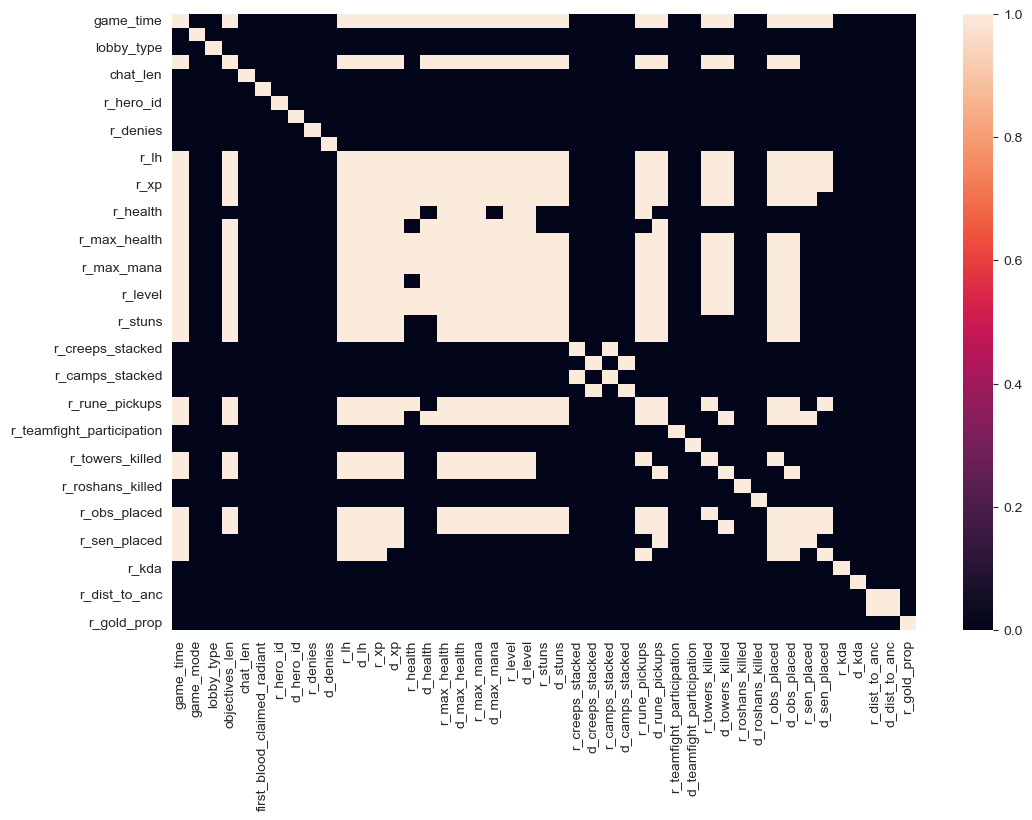

In [ ]:
sns.heatmap(df_train_features.corr() > 0.6)
;

Shall we normalize lh, xp, health, max_health, max_mana, level, stuns, rune_pickups, towers_killed, obs_placed and sen_placed per game time? YES (it ameliorated the model)

In [ ]:
per_time_norm_list = ['r_lh', 'd_lh',
       'r_xp', 'd_xp', 'r_health', 'd_health', 'r_max_health', 'd_max_health',
       'r_max_mana', 'd_max_mana', 'r_level', 'd_level', 'r_stuns', 'd_stuns', 
       'r_rune_pickups', 'd_rune_pickups', 'r_towers_killed', 'd_towers_killed',
       'r_obs_placed', 'd_obs_placed', 'r_sen_placed', 'd_sen_placed']

In [ ]:
for ftr in per_time_norm_list:
    df_train_features[f"{ftr}_per_time"] = df_train_features[f"{ftr}"] / (df_train_features["game_time"] + 1)
    df_test_features[f"{ftr}_per_time"] = df_test_features[f"{ftr}"] / (df_test_features["game_time"] + 1)
    df_train_features = df_train_features.drop(f"{ftr}", axis=1)
    df_test_features = df_test_features.drop(f"{ftr}", axis=1)

''

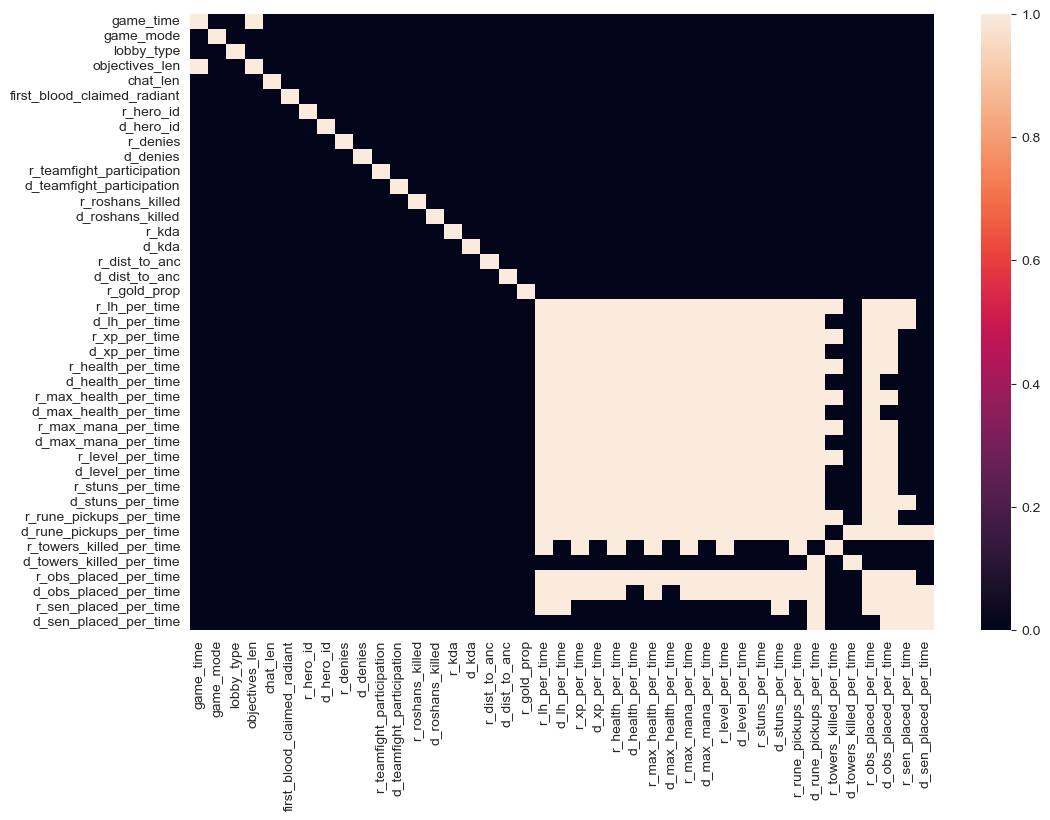

In [ ]:
sns.heatmap(df_train_features.drop(drop_list, axis=1).corr() > 0.8)
;

Shall I count lh per time, xp per time, health per time, max health per time, max mana per time, level per time, stuns per time, runes pickups per time, obs placed per time, sen placed per time as proportion as well and hence evaluate the disbalance between teams? YES (it ameloirated the model)

In [ ]:
disbalance = ['lh_per_time',
 'xp_per_time',
 'health_per_time',
 'max_health_per_time',
 'max_mana_per_time',
 'level_per_time',
 'stuns_per_time',
 'rune_pickups_per_time',
 'obs_placed_per_time',
 'sen_placed_per_time']

for ftr in disbalance:
    df_train_features[f"r_{ftr}_prop"] = df_train_features[f"r_{ftr}"] / (df_train_features[f"r_{ftr}"] + df_train_features[f"d_{ftr}"] + 1)
    df_test_features[f"r_{ftr}_prop"] = df_test_features[f"r_{ftr}"] / (df_test_features[f"r_{ftr}"] + df_test_features[f"d_{ftr}"] + 1)
    df_train_features = df_train_features.drop([f"r_{ftr}", f"d_{ftr}"], axis=1)
    df_test_features = df_test_features.drop([f"r_{ftr}", f"d_{ftr}"], axis=1)

''

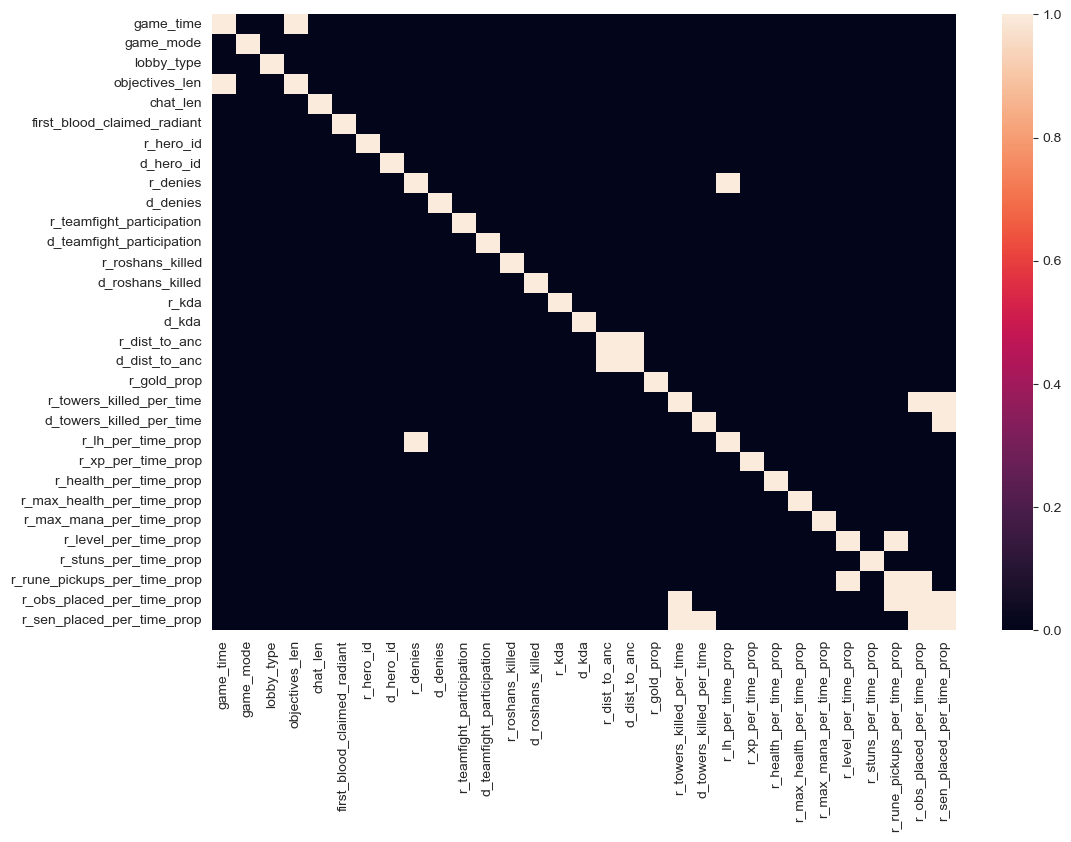

In [ ]:
sns.heatmap(df_train_features.drop(drop_list, axis=1).corr() > 0.6)
;

<AxesSubplot: >

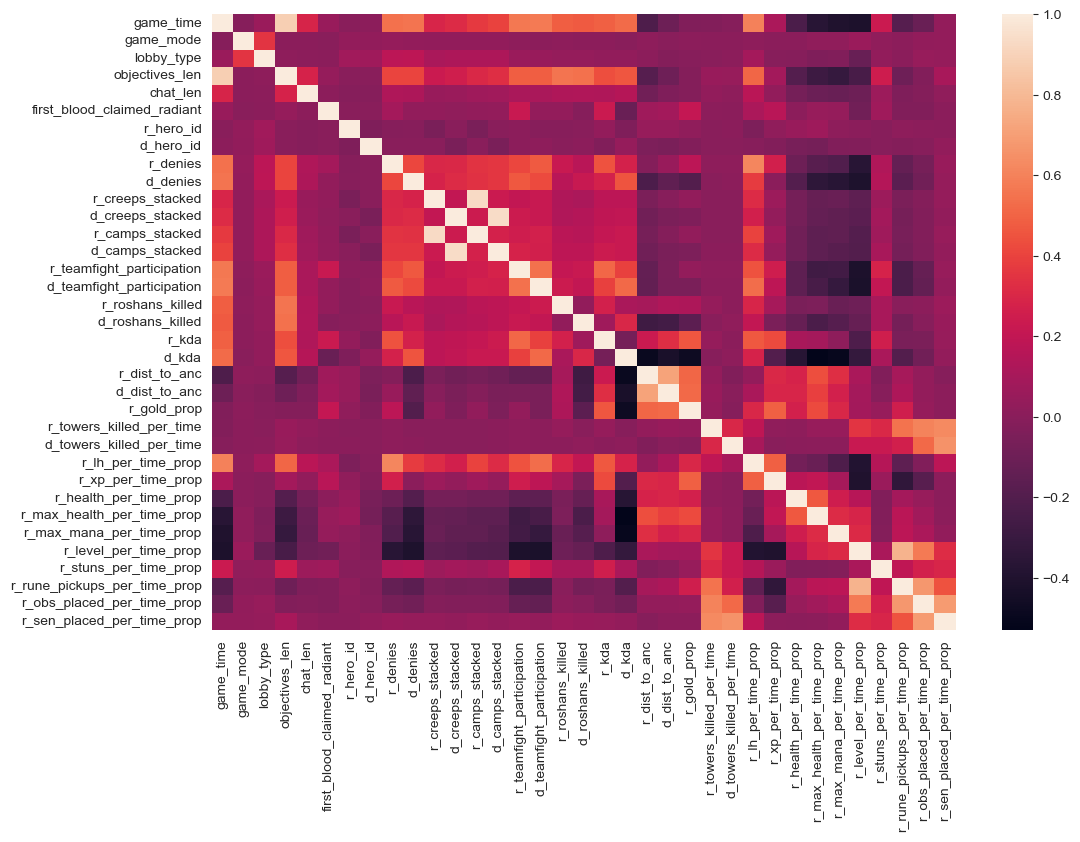

In [ ]:
sns.heatmap(df_train_features.corr())

Upsampling + standardation

In [ ]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,first_blood_claimed_radiant,r_hero_id,d_hero_id,r_denies,d_denies,...,r_lh_per_time_prop,r_xp_per_time_prop,r_health_per_time_prop,r_max_health_per_time_prop,r_max_mana_per_time_prop,r_level_per_time_prop,r_stuns_per_time_prop,r_rune_pickups_per_time_prop,r_obs_placed_per_time_prop,r_sen_placed_per_time_prop
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,0,2.531378,2.589738,28,16,...,0.143991,0.563917,0.531239,0.501016,0.455913,0.050964,0.059694,0.018950,0.005988,0.004518
6db558535151ea18ca70a6892197db41,21,23,0,0,0,0,2.504680,2.587266,0,0,...,0.000000,0.000000,0.496823,0.496699,0.509453,0.156250,0.000000,0.115385,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,0,2.492869,2.624720,9,5,...,0.090909,0.523860,0.580584,0.504202,0.479748,0.065217,0.042986,0.041667,0.006173,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,1,2.560871,2.397790,33,38,...,0.153901,0.479421,0.455123,0.458762,0.434607,0.043088,0.055981,0.030160,0.005825,0.001961
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,0,2.393454,2.600217,37,44,...,0.168862,0.479118,0.474057,0.489113,0.451197,0.045242,0.008406,0.014901,0.003396,0.000000


In [ ]:
df_train_features.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'first_blood_claimed_radiant', 'r_hero_id', 'd_hero_id', 'r_denies',
       'd_denies', 'r_creeps_stacked', 'd_creeps_stacked', 'r_camps_stacked',
       'd_camps_stacked', 'r_teamfight_participation',
       'd_teamfight_participation', 'r_roshans_killed', 'd_roshans_killed',
       'r_kda', 'd_kda', 'r_dist_to_anc', 'd_dist_to_anc', 'r_gold_prop',
       'r_towers_killed_per_time', 'd_towers_killed_per_time',
       'r_lh_per_time_prop', 'r_xp_per_time_prop', 'r_health_per_time_prop',
       'r_max_health_per_time_prop', 'r_max_mana_per_time_prop',
       'r_level_per_time_prop', 'r_stuns_per_time_prop',
       'r_rune_pickups_per_time_prop', 'r_obs_placed_per_time_prop',
       'r_sen_placed_per_time_prop'],
      dtype='object')

In [ ]:
num_cols = df_train_features.columns.tolist()
num_cols.remove('first_blood_claimed_radiant')
cat_cols = ['first_blood_claimed_radiant']
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_cols),
                  ("ohe", OneHotEncoder(drop="first"), cat_cols)]
)

In [ ]:
df_train_targets.radiant_win.value_counts()

True     16670
False    15028
Name: radiant_win, dtype: int64

In [ ]:
indexes = df_test_features.index

In [ ]:
df_train = pd.concat([df_train_features, df_train_targets.drop("game_time", axis=1)], axis=1)
rad_win = df_train[df_train.radiant_win == True]
dir_win = df_train[df_train.radiant_win == False]
reshape_val = rad_win.shape[0]
dir_win_up = resample(dir_win, random_state=SEED, n_samples=reshape_val, replace=True)
df_train_balanced = pd.concat([rad_win, dir_win_up])

In [ ]:
df_train_balanced.radiant_win.value_counts()

True     16670
False    16670
Name: radiant_win, dtype: int64

In [ ]:
X, y = df_train_balanced.drop(['radiant_win', 'duration', 'time_remaining',
       'next_roshan_team'], axis=1), df_train_balanced["radiant_win"].values.astype("int8")

In [ ]:
preprocessor.fit(X)
df_train_features_tr = preprocessor.transform(X)
df_test_features_tr = preprocessor.transform(df_test_features)

In [ ]:
X.shape, len(y)

((33340, 35), 33340)

In [ ]:
df_test_features.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'first_blood_claimed_radiant', 'r_hero_id', 'd_hero_id', 'r_denies',
       'd_denies', 'r_creeps_stacked', 'd_creeps_stacked', 'r_camps_stacked',
       'd_camps_stacked', 'r_teamfight_participation',
       'd_teamfight_participation', 'r_roshans_killed', 'd_roshans_killed',
       'r_kda', 'd_kda', 'r_dist_to_anc', 'd_dist_to_anc', 'r_gold_prop',
       'r_towers_killed_per_time', 'd_towers_killed_per_time',
       'r_lh_per_time_prop', 'r_xp_per_time_prop', 'r_health_per_time_prop',
       'r_max_health_per_time_prop', 'r_max_mana_per_time_prop',
       'r_level_per_time_prop', 'r_stuns_per_time_prop',
       'r_rune_pickups_per_time_prop', 'r_obs_placed_per_time_prop',
       'r_sen_placed_per_time_prop'],
      dtype='object')

Now let's try Random Forest. It is not bad so far.

In [ ]:
%%time
# hero ids as win proportion and sumed up
X = df_train_features_tr
y = y
rf_model = RandomForestClassifier(n_estimators=700, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8400976564665406
CPU times: user 8.05 s, sys: 764 ms, total: 8.81 s
Wall time: 39.9 s


In [ ]:
# hero ids as win proportion and sumed up
rf_model = RandomForestClassifier(n_estimators=700, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)
X_test = df_test_features_tr
rf_model
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-08_17-48-19.csv


''

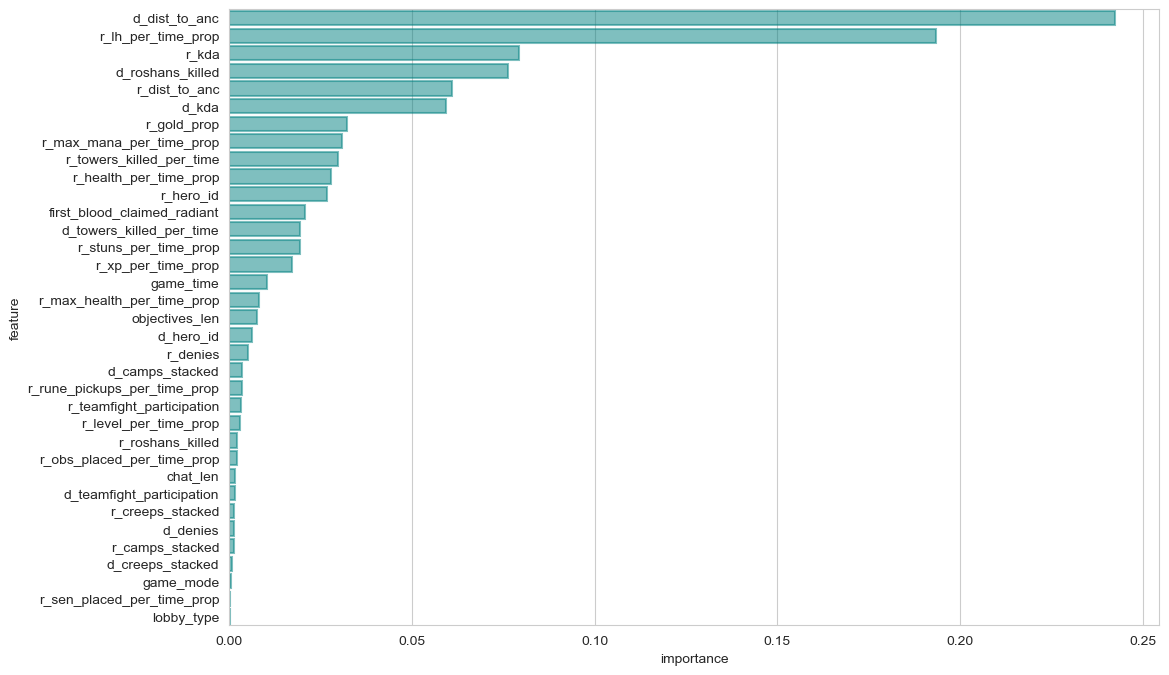

In [ ]:
ftr_imps = pd.DataFrame(list(zip(df_test_features.columns, rf_model.feature_importances_)), columns=["feature", "importance"])
sns.barplot(data=ftr_imps.sort_values("importance", ascending=False),
    x="importance", y="feature",
    linewidth=1.5, edgecolor="teal", facecolor='teal', alpha=0.5)
;

Will these data transformations work on the same model better on extended DF?

In [377]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d4_nearby_creep_death_count,d4_pred_vict,d5_ability_upgrades,d5_ability_uses,d5_purchases,d5_item_uses,d5_damage_given,d5_damage_taken,d5_nearby_creep_death_count,d5_pred_vict
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,55.0,False,4.0,7.0,12.0,9.0,2308.0,2154.0,27.0,False
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.0,False,0.0,0.0,4.0,1.0,0.0,0.0,0.0,False
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,11.0,False,0.0,2.0,9.0,2.0,4496.0,948.0,9.0,False
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,133.0,False,5.0,32.0,21.0,14.0,4682.0,1608.0,108.0,False
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,75.0,False,2.0,19.0,14.0,8.0,2156.0,1593.0,32.0,False


In [378]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


In [379]:
df_test_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d4_nearby_creep_death_count,d4_pred_vict,d5_ability_upgrades,d5_ability_uses,d5_purchases,d5_item_uses,d5_damage_given,d5_damage_taken,d5_nearby_creep_death_count,d5_pred_vict
match_id_hash,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,...,20.0,False,0.0,4.0,6.0,3.0,2332.0,681.0,17.0,False
46a0ddce8f7ed2a8d9bd5edcbb925682,576,22,7,1,4,14,1,0,3,1,...,33.0,True,3.0,19.0,13.0,11.0,3955.0,3317.0,75.0,False
b1b35ff97723d9b7ade1c9c3cf48f770,453,22,7,1,3,42,0,1,1,0,...,43.0,False,2.0,9.0,7.0,6.0,10739.0,2785.0,65.0,False
ab3cc6ccac661a1385e73a2e9f21313a,721,4,0,2,1,30,2,2,1,3,...,62.0,False,7.0,7.0,14.0,10.0,15255.0,5052.0,99.0,False
54aaab1cb8cc5df3c253641618673266,752,22,7,1,0,8,2,0,2,8,...,95.0,False,5.0,64.0,23.0,11.0,16086.0,5782.0,84.0,False


In [336]:
%%time 
# base model
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7787220332559414
CPU times: user 22.6 s, sys: 1.45 s, total: 24 s
Wall time: 48.8 s


Now feature transformation as I did with the original data

KDA

In [380]:
for team in ["r", "d"]:
    for player in range(1, 6):
        df_train_features_extended[f"{team}{player}_kda"] = (df_train_features_extended[f"{team}{player}_kills"] + df_train_features_extended[f"{team}{player}_assists"]) / (df_train_features_extended[f"{team}{player}_deaths"] + 1)
        df_test_features_extended[f"{team}{player}_kda"] = (df_test_features_extended[f"{team}{player}_kills"] + df_test_features_extended[f"{team}{player}_assists"]) / (df_test_features_extended[f"{team}{player}_deaths"] + 1)
drop_list = []
for team in ["r", "d"]:
    for player in range(1, 6):
        drop_list.append(f"{team}{player}_kills")
        drop_list.append(f"{team}{player}_assists")
        drop_list.append(f"{team}{player}_deaths")
df_train_features_extended = df_train_features_extended.drop(drop_list, axis=1)
df_test_features_extended = df_test_features_extended.drop(drop_list, axis=1)

rad_first_blood_features_list = ["r1_firstblood_claimed", "r2_firstblood_claimed", "r3_firstblood_claimed", "r4_firstblood_claimed", "r5_firstblood_claimed"]
dire_first_blood_features_list = ["d1_firstblood_claimed", "d2_firstblood_claimed", "d3_firstblood_claimed", "d4_firstblood_claimed", "d5_firstblood_claimed"]
df_train_features_extended["first_blood_claimed_radiant"] = df_train_features_extended[rad_first_blood_features_list].sum(axis=1)
df_train_features_extended = df_train_features_extended.drop(rad_first_blood_features_list + dire_first_blood_features_list, axis=1)
df_test_features_extended["first_blood_claimed_radiant"] = df_test_features_extended[rad_first_blood_features_list].sum(axis=1)
df_test_features_extended = df_test_features_extended.drop(rad_first_blood_features_list + dire_first_blood_features_list, axis=1)

In [221]:
%%time
# kda and first blood claim by team
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7852818518586497
CPU times: user 8.13 s, sys: 524 ms, total: 8.66 s
Wall time: 38.3 s


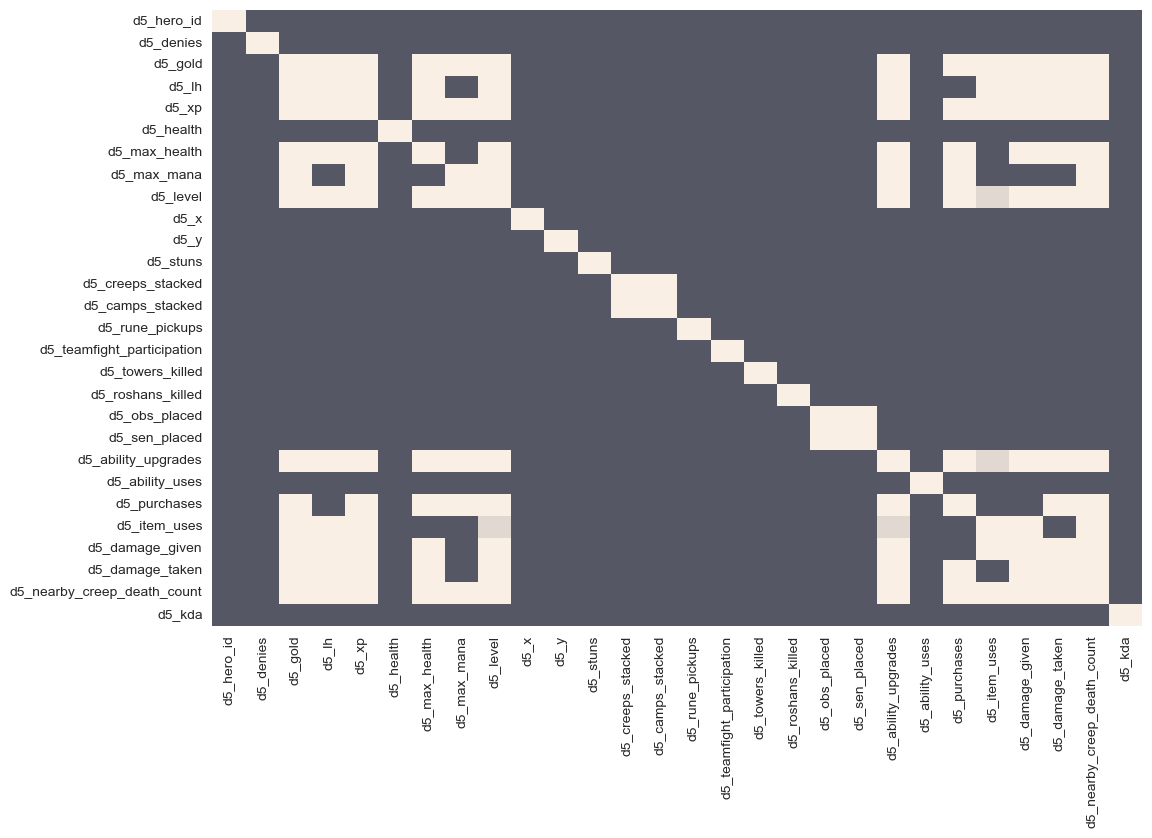

In [381]:
for cmnd in ["r", "d"]:
    for plr in range(1, 6):
        plr_id = f"{cmnd}{plr}"
        plr_ftrs_lst = [ftr for ftr in df_train_features_extended.columns if ftr.startswith(plr_id)]
        sns.heatmap(df_train_features_extended[plr_ftrs_lst].corr() > 0.6, alpha=0.1, cbar=False)


Hero ID as success rate

In [382]:
df_train_features_extended

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_denies,r1_gold,r1_lh,r1_xp,...,r2_kda,r3_kda,r4_kda,r5_kda,d1_kda,d2_kda,d3_kda,d4_kda,d5_kda,first_blood_claimed_radiant
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,5257,52,3937,...,2.500000,2.500000,7.000000,6.000000,0.333333,0.142857,0.500000,0.500000,0.000000,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,176,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,1,403,0,359,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,5,3085,1,2828,...,1.333333,1.000000,2.000000,1.333333,0.800000,4.000000,2.333333,1.500000,1.500000,1
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,9,3516,40,3964,...,0.428571,2.000000,0.500000,0.000000,3.000000,0.666667,5.000000,1.000000,1.666667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b794aa55646841a03c7783226e6f6bc8,2666,22,0,23,8,99,3,19850,251,25448,...,1.818182,1.666667,2.857143,2.428571,1.352941,3.444444,13.000000,4.666667,3.200000,0
308faee28efee2e66b39f9f2ba6ea9cf,2525,22,0,15,5,22,3,13914,151,19592,...,1.571429,5.000000,15.000000,2.500000,1.750000,1.142857,1.200000,0.250000,0.625000,0
6066cc7417b43c749d551e123d00f0c8,1002,4,0,4,0,1,0,4613,59,4478,...,0.600000,0.428571,1.000000,1.250000,8.000000,5.000000,3.333333,2.400000,5.000000,0


In [383]:
plrs = [f"{i}_hero_id" for i in plrs]
for plr in plrs:
    df_train_features_extended[plr] = df_train_features_extended[plr].apply(lambda x: win_proportion_dict[x])
    df_test_features_extended[plr] = df_test_features_extended[plr].apply(lambda x: win_proportion_dict[x])

X and y => distances from Ancients

In [384]:
ancient_coord = (x_min, y_min)
plrs = []
for tm in ["r", "d"]:
    for plr in range(1, 6):
        plrs.append(f"{tm}{plr}")

In [385]:
df_train_features_extended = distance_to_ancient(df_train_features_extended, ancient_coord[0], ancient_coord[1])
df_test_features_extended = distance_to_ancient(df_test_features_extended, ancient_coord[0], ancient_coord[1])

Sum up features per team

In [386]:
plr_ftrs_lst = [ftr[3:] for ftr in df_train_features_extended.columns if ftr.startswith("r1")]

for feature in plr_ftrs_lst:
    df_train_features_extended = sum_up_ftrs_by_plr(df=df_train_features_extended, ftr=feature)
    df_test_features_extended = sum_up_ftrs_by_plr(df=df_test_features_extended, ftr=feature)

In [228]:
%%time
# sumed featues
X = df_train_features_extended.values
y = df_train_targets["radiant_win"].values.astype("int8")
rf_model = RandomForestClassifier(n_estimators=700, max_depth=19, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8208474507971347
CPU times: user 16.1 s, sys: 979 ms, total: 17.1 s
Wall time: 1min 20s


''

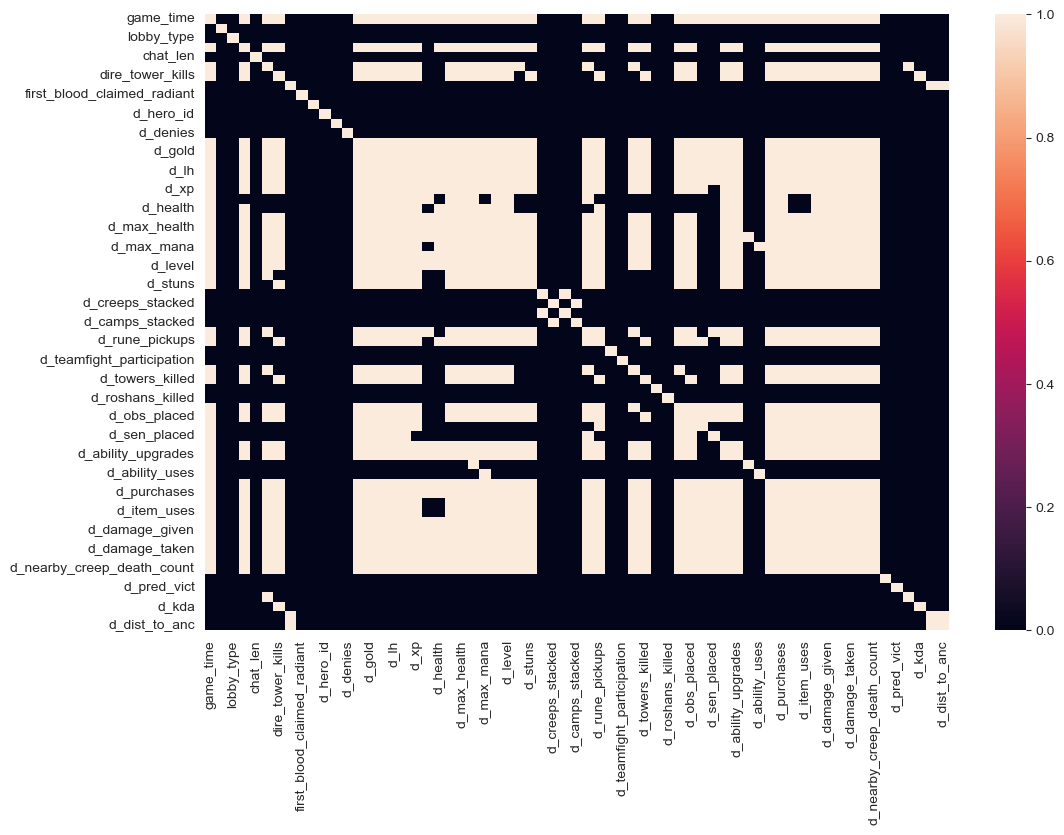

In [387]:
sns.heatmap(df_train_features_extended.corr() > 0.6)
;

Gold proportion and other features proportion (normalized per time but as far as they're proportions it does not make any sence but anyway i'll leave it like that)

In [388]:
df_train_features_extended["r_gold_prop"] = df_train_features_extended.r_gold / (df_train_features_extended.r_gold + df_train_features_extended.d_gold + 1)
df_test_features_extended["r_gold_prop"] = df_test_features_extended.r_gold / (df_test_features_extended.r_gold + df_test_features_extended.d_gold + 1)
df_train_features_extended = df_train_features_extended.drop(["r_gold", "d_gold"], axis=1)
df_test_features_extended = df_test_features_extended.drop(["r_gold", "d_gold"], axis=1)

In [389]:
df_test_features_extended.columns

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len',
       'radiant_tower_kills', 'dire_tower_kills', 'diff_tower_kills',
       'first_blood_claimed_radiant', 'r_hero_id', 'd_hero_id', 'r_denies',
       'd_denies', 'r_lh', 'd_lh', 'r_xp', 'd_xp', 'r_health', 'd_health',
       'r_max_health', 'd_max_health', 'r_max_mana', 'd_max_mana', 'r_level',
       'd_level', 'r_stuns', 'd_stuns', 'r_creeps_stacked', 'd_creeps_stacked',
       'r_camps_stacked', 'd_camps_stacked', 'r_rune_pickups',
       'd_rune_pickups', 'r_teamfight_participation',
       'd_teamfight_participation', 'r_towers_killed', 'd_towers_killed',
       'r_roshans_killed', 'd_roshans_killed', 'r_obs_placed', 'd_obs_placed',
       'r_sen_placed', 'd_sen_placed', 'r_ability_upgrades',
       'd_ability_upgrades', 'r_ability_uses', 'd_ability_uses', 'r_purchases',
       'd_purchases', 'r_item_uses', 'd_item_uses', 'r_damage_given',
       'd_damage_given', 'r_damage_taken', 'd_damage_taken',
  

In [390]:
per_time_norm_list = ['r_lh', 'd_lh',
       'r_xp', 'd_xp', 'r_health', 'd_health', 'r_max_health', 'd_max_health',
       'r_max_mana', 'd_max_mana', 'r_level', 'd_level', 'r_stuns', 'd_stuns', 
       'r_rune_pickups', 'd_rune_pickups', 'r_towers_killed', 'd_towers_killed',
       'r_obs_placed', 'd_obs_placed', 'r_sen_placed', 'd_sen_placed', 
       'r_ability_upgrades', 'd_ability_upgrades', 'r_ability_uses', 'd_ability_uses', 
       'r_purchases', 'd_purchases', 'r_item_uses', 'd_item_uses', 
       'r_damage_given', 'd_damage_given', 'r_damage_taken', 'd_damage_taken',
       'r_nearby_creep_death_count', 'd_nearby_creep_death_count']

for ftr in per_time_norm_list:
    df_train_features_extended[f"{ftr}_per_time"] = df_train_features_extended[f"{ftr}"] / (df_train_features_extended["game_time"] + 1)
    df_test_features_extended[f"{ftr}_per_time"] = df_test_features_extended[f"{ftr}"] / (df_test_features_extended["game_time"] + 1)
    df_train_features_extended = df_train_features_extended.drop(f"{ftr}", axis=1)
    df_test_features_extended = df_test_features_extended.drop(f"{ftr}", axis=1)

''

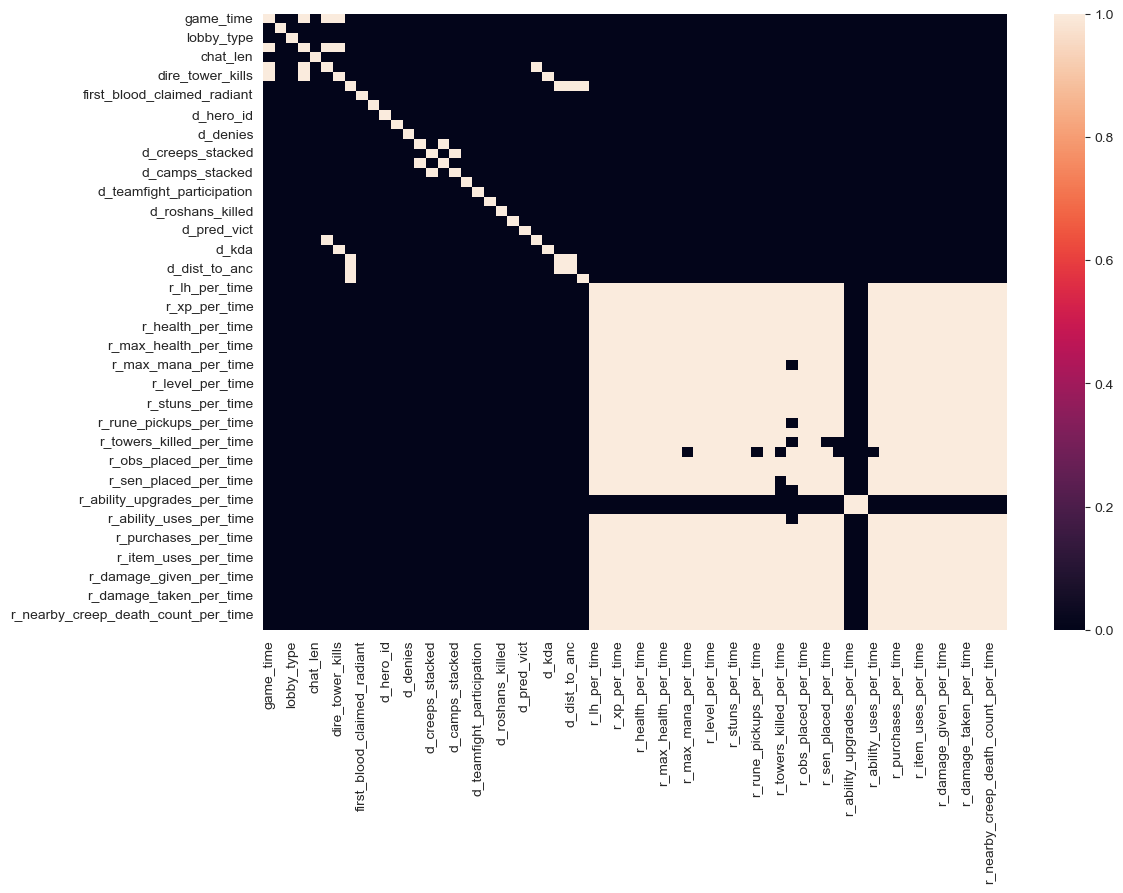

In [391]:
sns.heatmap(df_train_features_extended.corr() > 0.6)
;

count all new features as proportion per team (which kills per time normalization, but okay)

In [392]:
disbalance = ['lh_per_time',
 'xp_per_time',
 'health_per_time',
 'max_health_per_time',
 'max_mana_per_time',
 'level_per_time',
 'stuns_per_time',
 'rune_pickups_per_time',
 'obs_placed_per_time',
 'sen_placed_per_time',
 'ability_upgrades_per_time',
 'ability_uses_per_time',
 'purchases_per_time',
 'item_uses_per_time',
 'damage_given_per_time',
 'damage_taken_per_time',
 'nearby_creep_death_count_per_time']

for ftr in disbalance:
    df_train_features_extended[f"r_{ftr}_prop"] = df_train_features_extended[f"r_{ftr}"] / (df_train_features_extended[f"r_{ftr}"] + df_train_features_extended[f"d_{ftr}"] + 1)
    df_test_features_extended[f"r_{ftr}_prop"] = df_test_features_extended[f"r_{ftr}"] / (df_test_features_extended[f"r_{ftr}"] + df_test_features_extended[f"d_{ftr}"] + 1)
    df_train_features_extended = df_train_features_extended.drop([f"r_{ftr}", f"d_{ftr}"], axis=1)
    df_test_features_extended = df_test_features_extended.drop([f"r_{ftr}", f"d_{ftr}"], axis=1)

''

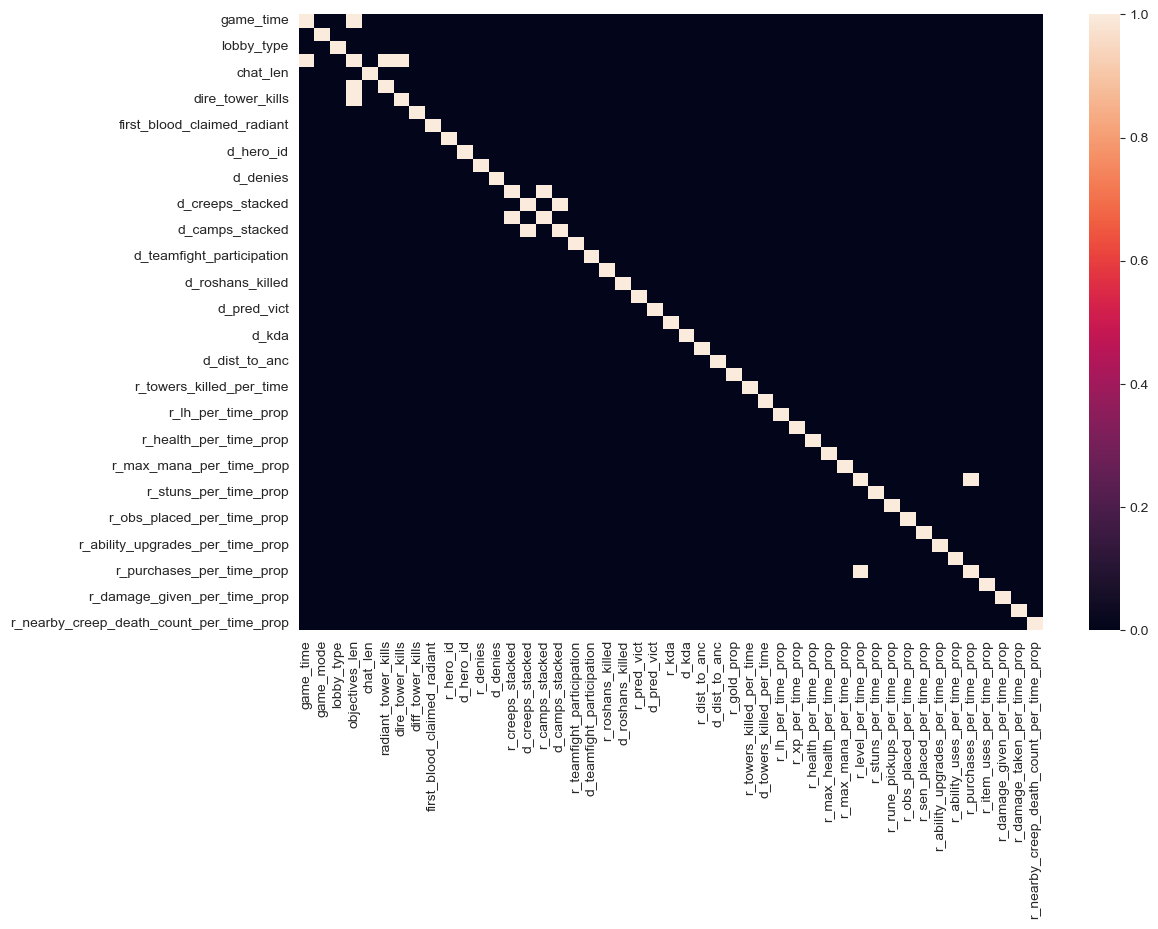

In [393]:
sns.heatmap(df_train_features_extended.corr() > 0.8)
;

Pred_vict as difference between radiant and dire

In [397]:
df_train_features_extended['pred_vict_difference'] = df_train_features_extended.r_pred_vict - df_train_features_extended.d_pred_vict
df_test_features_extended['pred_vict_difference'] = df_test_features_extended.r_pred_vict - df_test_features_extended.d_pred_vict
df_train_features_extended = df_train_features_extended.drop(['r_pred_vict', 'd_pred_vict'], axis=1)
df_test_features_extended = df_test_features_extended.drop(['r_pred_vict', 'd_pred_vict'], axis=1)

Upsampling + standardation

In [448]:
num_cols = df_train_features_extended.columns.tolist()
num_cols.remove('first_blood_claimed_radiant')
cat_cols = ['first_blood_claimed_radiant']
preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), num_cols),
                  ("ohe", OneHotEncoder(drop="first"), cat_cols)]
)

indexes = df_test_features.index

df_train_targets.radiant_win.value_counts()

True     16670
False    15028
Name: radiant_win, dtype: int64

In [433]:
df_train_ext = pd.concat([df_train_features_extended, df_train_targets.drop("game_time", axis=1)], axis=1)
rad_win = df_train_ext[df_train_ext.radiant_win == True]
dir_win = df_train_ext[df_train_ext.radiant_win == False]
reshape_val = rad_win.shape[0]
dir_win_up = resample(dir_win, random_state=SEED, n_samples=reshape_val, replace=True)
df_train_ext_balanced = pd.concat([rad_win, dir_win_up])
df_train_ext_balanced.radiant_win.value_counts()

True     16670
False    16670
Name: radiant_win, dtype: int64

In [441]:
X, y = df_train_ext_balanced.drop(['radiant_win', 'duration', 'time_remaining',
       'next_roshan_team'], axis=1), df_train_ext_balanced["radiant_win"].values.astype("int8")

preprocessor.fit(X)
df_train_features_tr = preprocessor.transform(X)
df_test_features_tr = preprocessor.transform(df_test_features_extended)

X.shape, len(y)

((33340, 46), 33340)

Now, applying RandomForest to this extended dotaset

In [247]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
rf_model = RandomForestClassifier(n_estimators=700, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8408896301884274
CPU times: user 9.9 s, sys: 866 ms, total: 10.8 s
Wall time: 44 s


In [248]:
# extended dotaset BEST AS FAR on kaggle it gave 0.84015 score
rf_model = RandomForestClassifier(n_estimators=700, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)
X_test = df_test_features_tr
rf_model
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_19-03-11.csv


''

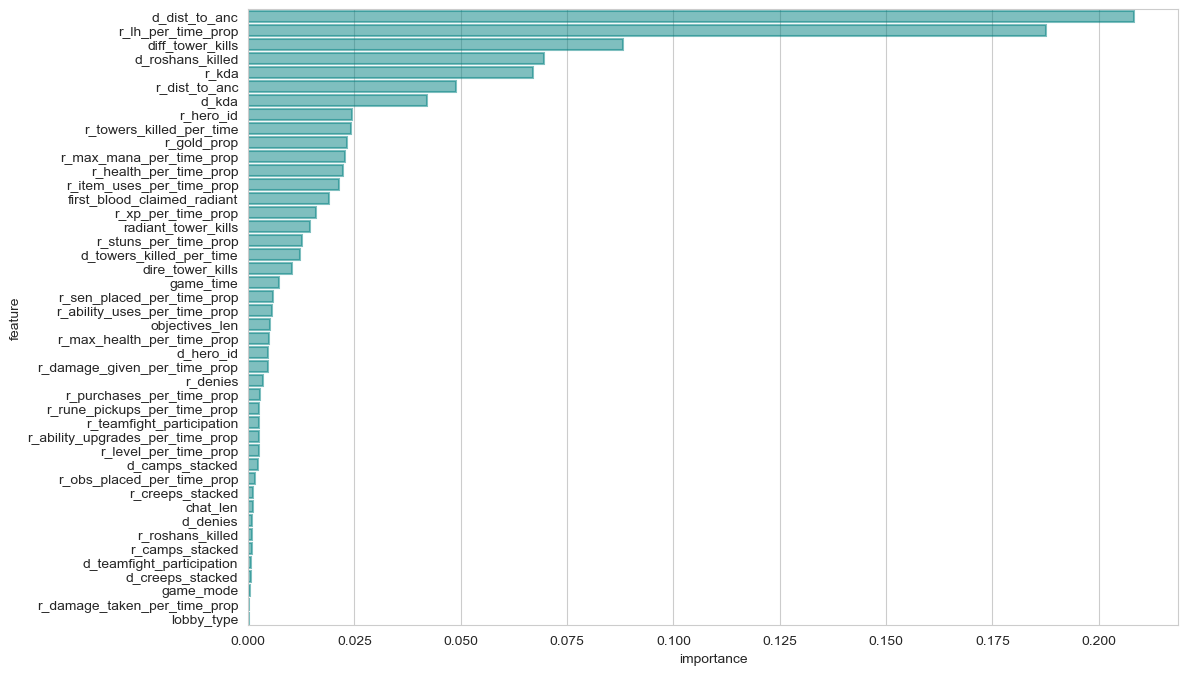

In [249]:
ftr_imps = pd.DataFrame(list(zip(df_test_features_extended.columns, rf_model.feature_importances_)), columns=["feature", "importance"])
sns.barplot(data=ftr_imps.sort_values("importance", ascending=False),
    x="importance", y="feature",
    linewidth=1.5, edgecolor="teal", facecolor='teal', alpha=0.5)
;

Now I made sure that extended DF is better and want to try other models.

In [250]:
import xgboost
import catboost

In [251]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
cat_mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED,
                                  n_estimators=350, max_depth=11)
cv_scores_cb = cross_val_score(cat_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.912193335535936
CPU times: user 19min 10s, sys: 17.8 s, total: 19min 28s
Wall time: 3min 39s


In [252]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
cat_mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED,
                                  n_estimators=700, max_depth=11)
cv_scores_cb = cross_val_score(cat_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.9150766864082801
CPU times: user 38min 54s, sys: 38.9 s, total: 39min 33s
Wall time: 7min 18s


In [257]:
# extended dotaset is worse than RF
cat_mdl = catboost.CatBoostClassifier(verbose=False, random_state=SEED,
                                  n_estimators=700, max_depth=11)
cat_mdl.fit(X, y)
X_test = df_test_features_tr
cat_mdl
y_test_pred = cat_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_20-16-30.csv


In [255]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=240, max_depth=7, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8478161514415096
CPU times: user 6min 31s, sys: 2.51 s, total: 6min 33s
Wall time: 53.7 s


In [256]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=7, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8478865222757868
CPU times: user 21min 22s, sys: 11.7 s, total: 21min 34s
Wall time: 3min 2s


In [265]:
# extended dotaset slightly better than RF BEST AS FAR
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=7, random_state=SEED)
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_20-20-42.csv


Okay, I'll try to find best hyperparameters for XGBRFClassifier

In [ ]:
rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
rf_random.best_params_

In [271]:
random_grid = {
    'max_depth': [1, 5,  50, -1],
    'n_estimators':[1, 10 , 100],
    'learning_rate': np.linspace(0.01,0.5,4),
    'reg_alpha': [0, 0.2, 1],
    'reg_lambda': [0, 0.2, 1],
}

xgb_mdl = xgboost.XGBRFClassifier()

xgb_rand_search = RandomizedSearchCV(estimator = xgb_mdl, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)

xgb_rand_search.fit(X, y)
xgb_rand_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.5, max_depth=-1, n_estimators=100, reg_alpha=0, reg_lambda=0.2; total time=   0.1s
[CV] END learning_rate=0.5, max_depth=-1, n_estimators=100, reg_alpha=0, reg_lambda=0.2; total time=   0.1s
[CV] END learning_rate=0.5, max_depth=-1, n_estimators=100, reg_alpha=0, reg_lambda=0.2; total time=   0.1s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.2, reg_lambda=0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.2, reg_lambda=0; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=5, n_estimators=1, reg_alpha=0.2, reg_lambda=0; total time=   0.3s
[CV] END learning_rate=0.5, max_depth=50, n_estimators=10, reg_alpha=0.2, reg_lambda=1; total time=   5.2s
[CV] END learning_rate=0.5, max_depth=50, n_estimators=10, reg_alpha=0.2, reg_lambda=1; total time=   5.7s
[CV] END learning_rate=0.33666666666666667, max_depth=50, n_estimators=1, reg_alpha

{'reg_lambda': 0,
 'reg_alpha': 0,
 'n_estimators': 100,
 'max_depth': 50,
 'learning_rate': 0.17333333333333334}

In [274]:
%%time
best_xgb = xgb_rand_search.best_estimator_
best_xgb_scores_cb = cross_val_score(best_xgb, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {best_xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.9107475944056039
CPU times: user 7min 13s, sys: 3.84 s, total: 7min 17s
Wall time: 58.9 s


In [275]:
# extended dotaset + better params(?) slightly better than RF
xgb_mdl = best_xgb
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_20-44-23.csv


In [276]:
random_grid = {
    'max_depth': np.arange(1, 30, 5),
    'n_estimators': np.arange(50, 500, 10),
    'learning_rate': np.linspace(0.01,0.5,4),
    'reg_alpha': [0, 0.2, 1],
    'reg_lambda': [0, 0.2, 1],
}

xgb_mdl = xgboost.XGBRFClassifier()

xgb_rand_search = RandomizedSearchCV(estimator = xgb_mdl, param_distributions = random_grid, cv = 3, verbose=2, random_state=42, n_jobs = -1)

xgb_rand_search.fit(X, y)
xgb_rand_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.33666666666666667, max_depth=6, n_estimators=180, reg_alpha=1, reg_lambda=1; total time=  30.5s
[CV] END learning_rate=0.33666666666666667, max_depth=6, n_estimators=180, reg_alpha=1, reg_lambda=1; total time=  30.5s
[CV] END learning_rate=0.01, max_depth=11, n_estimators=100, reg_alpha=0.2, reg_lambda=1; total time=  34.8s
[CV] END learning_rate=0.01, max_depth=11, n_estimators=100, reg_alpha=0.2, reg_lambda=1; total time=  35.8s
[CV] END learning_rate=0.01, max_depth=11, n_estimators=100, reg_alpha=0.2, reg_lambda=1; total time=  38.2s
[CV] END learning_rate=0.33666666666666667, max_depth=1, n_estimators=410, reg_alpha=1, reg_lambda=0.2; total time=  13.8s
[CV] END learning_rate=0.33666666666666667, max_depth=1, n_estimators=410, reg_alpha=1, reg_lambda=0.2; total time=  11.9s
[CV] END learning_rate=0.33666666666666667, max_depth=1, n_estimators=410, reg_alpha=1, reg_lambda=0.2; total time=  13.1s
[

{'reg_lambda': 0.2,
 'reg_alpha': 0,
 'n_estimators': 260,
 'max_depth': 16,
 'learning_rate': 0.33666666666666667}

In [277]:
%%time
best_xgb = xgb_rand_search.best_estimator_
best_xgb_scores_cb = cross_val_score(best_xgb, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {best_xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.9055695068283935
CPU times: user 19min 1s, sys: 8.88 s, total: 19min 9s
Wall time: 2min 38s


In [278]:
# extended dotaset + better params(?) slightly better than RF
xgb_mdl = best_xgb
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_21-01-37.csv


In [283]:
xgb_rand_search.best_estimator_

XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bytree=None,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
                grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.33666666666666667,
                max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=16, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=260, n_jobs=None, num_parallel_tree=None,
                objective='binary:logistic', predictor=None, random_state=None, ...)

In [281]:
from hyperopt import fmin, hp, STATUS_OK, Trials, tpe

In [284]:
space = {'max_depth': hp.quniform('max_depth', 1, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha': hp.quniform('reg_alpha', 10, 100, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.uniform('n_estimators', 10, 100),
        'seed': SEED,
    }

In [287]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.25, random_state=SEED)

In [288]:
def objective(space):
    mdl = xgboost.XGBClassifier(n_estimators=int(space['n_estimators']), 
                              max_depth=int(space['max_depth']),
                              reg_alpha=int(space['reg_alpha']),
                              min_child_weight=int(space['min_child_weight']),
                              colsample_bytree=space['colsample_bytree'],
                              gamma=space['gamma'],
                              reg_lambda=space['reg_lambda'],
                             )
    
    evaluation = [(X_tr, y_tr), (X_te, y_te)]
    
    mdl.fit(X_tr, y_tr,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = mdl.predict(X_te)
    roc_auc = roc_auc_score(y_te, pred>0.5)
    print ("SCORE:", roc_auc)
    return {'loss': -roc_auc, 'status': STATUS_OK }

In [289]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=300,
                        trials=trials)

SCORE:                                                 
0.7513634340883917                                     
SCORE:                                                                            
0.755151019723742                                                                 
SCORE:                                                                            
0.7483487634166751                                                               
SCORE:                                                                           
0.7518972046419697                                                               
SCORE:                                                                           
0.7559947912239934                                                               
SCORE:                                                                            
0.7703491565970344                                                                
SCORE:                                                         

In [290]:
print(best_hyperparams)

{'colsample_bytree': 0.7612928819881977, 'gamma': 1.1644796265046675, 'max_depth': 14.0, 'min_child_weight': 1.0, 'n_estimators': 84.47773701271012, 'reg_alpha': 10.0, 'reg_lambda': 0.605687781863435}


In [294]:
%%time
# extended dotaset xgbrf params from hyperopt
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=100, max_depth=14, colsample_bytree=0.76, gamma=1.16, min_child_weight=1, reg_alpha=10, reg_lambda=0.6, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8488666886961663
CPU times: user 3min 52s, sys: 2.04 s, total: 3min 54s
Wall time: 32.3 s


In [295]:
%%time
# extended dotaset xgbrf params from hyperopt
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=200, max_depth=14, colsample_bytree=0.76, gamma=1.16, min_child_weight=1, reg_alpha=10, reg_lambda=0.6, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8490291232311364
CPU times: user 8min 31s, sys: 4.3 s, total: 8min 35s
Wall time: 1min 10s


In [300]:
%%time
# extended dotaset xgbrf params from hyperopt
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=7, colsample_bytree=0.76, gamma=1.16, min_child_weight=1, reg_alpha=10, reg_lambda=0.6, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8399883282848781
CPU times: user 14min 13s, sys: 5.05 s, total: 14min 18s
Wall time: 1min 54s


In [301]:
# extended dotaset slightly better than RF BEST HYPERPARAMS
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=7, colsample_bytree=0.76, gamma=1.16, min_child_weight=1, reg_alpha=10, reg_lambda=0.6, random_state=SEED)
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_21-58-52.csv


I forgot about learning rate!

In [302]:
space = {'max_depth': hp.quniform('max_depth', 1, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'eta': hp.uniform('eta', 0, 1),
        'reg_alpha': hp.quniform('reg_alpha', 10, 100, 1),
        'reg_lambda': hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform('n_estimators', 200, 700, 50),
        'seed': SEED
    }

In [303]:
def objective(space):
    mdl = xgboost.XGBClassifier(n_estimators=int(space['n_estimators']), 
                              max_depth=int(space['max_depth']),
                              reg_alpha=int(space['reg_alpha']),
                              min_child_weight=int(space['min_child_weight']),
                              colsample_bytree=space['colsample_bytree'],
                              gamma=space['gamma'],
                              reg_lambda=space['reg_lambda'],
                              eta=space['eta']
                             )
    
    evaluation = [(X_tr, y_tr), (X_te, y_te)]
    
    mdl.fit(X_tr, y_tr,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = mdl.predict(X_te)
    roc_auc = roc_auc_score(y_te, pred>0.5)
    print ("SCORE:", roc_auc)
    return {'loss': -roc_auc, 'status': STATUS_OK }

In [304]:
trials = Trials()

best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=300,
                        trials=trials)

SCORE:                                                 
0.7545164779884643                                     
SCORE:                                                                            
0.7564235006227082                                                                
SCORE:                                                                            
0.7505171001209483                                                                
SCORE:                                                                            
0.7463469294963352                                                                
SCORE:                                                                            
0.7543098106906821                                                                
SCORE:                                                                            
0.7537837275386794                                                                
SCORE:                                                    

In [305]:
print(best_hyperparams)

{'colsample_bytree': 0.6390806383770113, 'eta': 0.057884932782664975, 'gamma': 1.34439452983124, 'max_depth': 12.0, 'min_child_weight': 1.0, 'n_estimators': 700.0, 'reg_alpha': 12.0, 'reg_lambda': 0.5157939591884695}


In [310]:
%%time
# extended dotaset xgbrf params from hyperopt + learning rate
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=12, eta=0.0578, colsample_bytree=0.64, gamma=1.344, min_child_weight=1, reg_alpha=12, reg_lambda=0.516, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8452646025565423
CPU times: user 21min 3s, sys: 8.38 s, total: 21min 11s
Wall time: 2min 51s


In [311]:
# extended dotaset slightly better than RF 
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=12, eta=0.0578, colsample_bytree=0.64, gamma=1.344, min_child_weight=1, reg_alpha=12, reg_lambda=0.516, random_state=SEED)
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-09_23-32-58.csv


In [403]:
%%time
# extended dotaset xgbrf params from hyperopt + learning rate BEST AS FAR
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=12, eta=0.0578, colsample_bytree=0.64, gamma=1.344, min_child_weight=1, reg_alpha=12, reg_lambda=0.516, random_state=SEED)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8449916005203267
CPU times: user 26min 5s, sys: 13.1 s, total: 26min 18s
Wall time: 3min 41s


In [404]:
# extended dotaset slightly better than RF 
xgb_mdl = xgboost.XGBRFClassifier(n_estimators=700, max_depth=12, eta=0.0578, colsample_bytree=0.64, gamma=1.344, min_child_weight=1, reg_alpha=12, reg_lambda=0.516, random_state=SEED)
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-10_00-50-57.csv


Try boosting XGBC

In [418]:
%%time
# extended dotaset xgbrf params from hyperopt + learning rate BEST AS FAR
X = df_train_features_tr
y = y
xgb_mdl = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=SEED
)
xgb_scores_cb = cross_val_score(xgb_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {xgb_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8970959320738435
CPU times: user 10min 16s, sys: 5.16 s, total: 10min 22s
Wall time: 1min 27s


In [419]:
# extended dotaset slightly better than RF 
xgb_mdl = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    n_estimators=500,
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    seed=SEED
)
xgb_mdl.fit(X, y)
X_test = df_test_features_tr
xgb_mdl
y_test_pred = xgb_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-10_01-12-08.csv


Now i'll try catboost

In [407]:
%%time
# extended dotaset
X = df_train_features_tr
y = y
cat_mdl = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=1,
    random_seed=SEED,
    eval_metric="AUC",
    verbose=0,
)
cv_scores_cb = cross_val_score(cat_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8785165370039281
CPU times: user 3min 12s, sys: 12.8 s, total: 3min 25s
Wall time: 41.3 s


In [408]:
# extended dotaset is worse than RF
cat_mdl = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=1,
    random_seed=SEED,
    eval_metric="AUC",
    verbose=0,
)
cat_mdl.fit(X, y)
X_test = df_test_features_tr
cat_mdl
y_test_pred = cat_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-10_00-57-25.csv


Best model

In [410]:
%%time
# extended dotaset BEST MODEL AS FAR
X = df_train_features_tr
y = y
cat_mdl = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    border_count=254,
    bagging_temperature=1,
    random_strength=1,
    random_seed=SEED,
    eval_metric="AUC",
    verbose=0,
)
cv_scores_cb = cross_val_score(cat_mdl, X, y, cv=cv, scoring="roc_auc")
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_cb.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.8504842299286703
CPU times: user 3min 12s, sys: 13.1 s, total: 3min 25s
Wall time: 43.4 s


In [411]:
# extended dotaset is worse than RF BEST AS FAR
cat_mdl = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    border_count=254,
    bagging_temperature=1,
    random_strength=1,
    random_seed=SEED,
    eval_metric="AUC",
    verbose=0,
)
cat_mdl.fit(X, y)
X_test = df_test_features_tr
cat_mdl
y_test_pred = cat_mdl.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=indexes)
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2023-04-10_01-00-41.csv


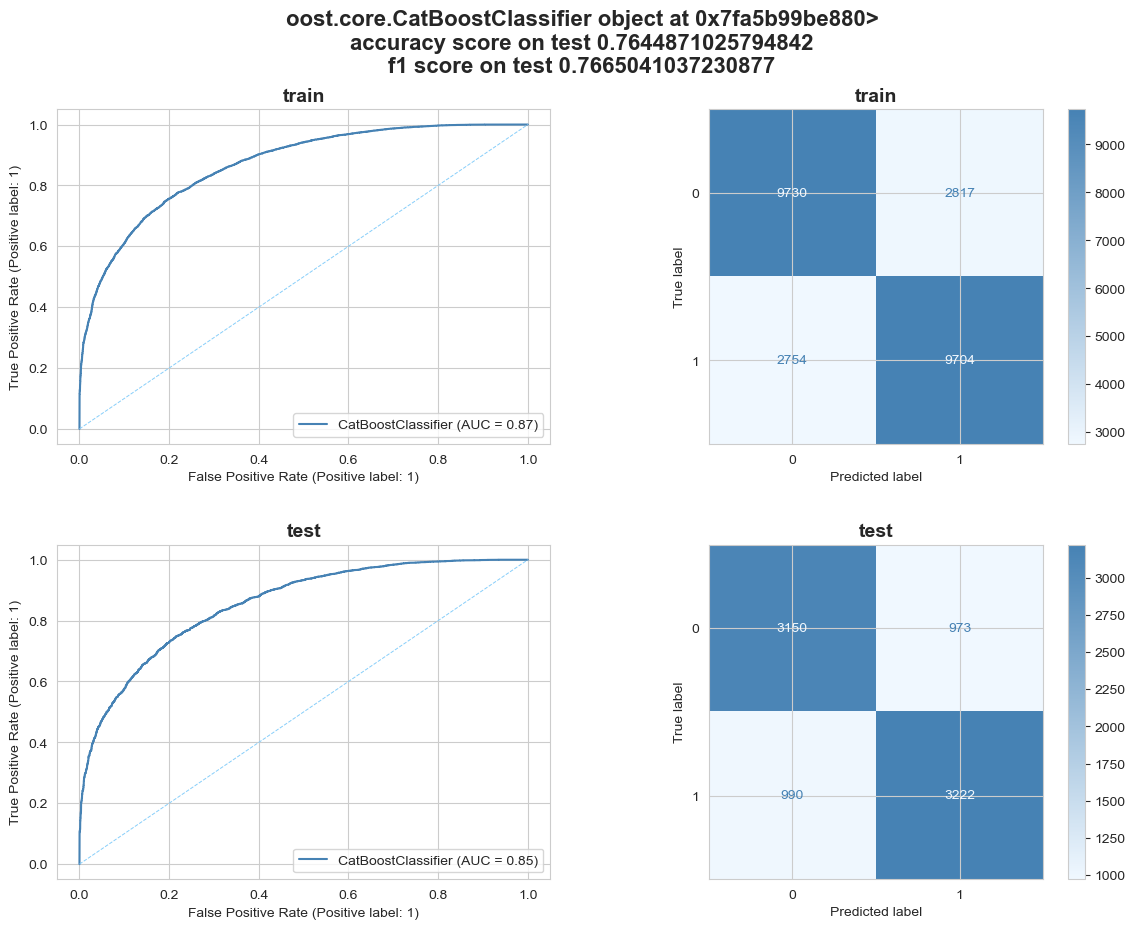

In [455]:
mdl = catboost.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.01,
    depth=6,
    l2_leaf_reg=3,
    border_count=254,
    bagging_temperature=1,
    random_strength=1,
    random_seed=SEED,
    eval_metric="AUC",
    verbose=0,
)
mdl.fit(X_tr, y_tr)
y_pr_tr = mdl.predict(X_tr)
y_pr_te = mdl.predict(X_te)
roc_auc_score(y_te, y_pr_te)
conf_mtr(mdl, X_tr, y_tr, y_pr_tr, X_te, y_te, y_pr_te)

In [454]:
def conf_mtr(best_mdl, X_train, y_train, y_pred_train, X_test, y_test, y_pred_test):
    """just in case wrote a funtion to demonstrate confusion matrix and roc-auc curve for train/test validation"""
    fig, ax = plt.subplots(2, 2, figsize=(14, 10))
    ax[0][1].set_title("train", size=14, weight='bold')
    ax[1][1].set_title("test", size=14, weight='bold')

    cm_train = confusion_matrix(y_train, y_pred_train, labels=best_mdl.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_train,
                                display_labels=best_mdl.classes_)
    disp.plot(ax=ax[0][1], cmap=sns.color_palette("blend:aliceblue,steelblue", as_cmap=True))

    cm_test = confusion_matrix(y_test, y_pred_test, labels=best_mdl.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                                display_labels=best_mdl.classes_)
    disp.plot(ax=ax[1][1], cmap=sns.color_palette("blend:aliceblue,steelblue", as_cmap=True))

    ax[0][0].set_title("train", size=14, weight='bold')
    ax[1][0].set_title("test", size=14, weight='bold')

    RocCurveDisplay.from_estimator(best_mdl, X_train, y_train, ax=ax[0][0], color='steelblue')
    ax[0][0].plot([0, 1], linestyle='--', color='lightskyblue', linewidth=0.7)

    RocCurveDisplay.from_estimator(best_mdl, X_test, y_test, ax=ax[1][0], color='steelblue')
    ax[1][0].plot([0, 1], linestyle='--', color='lightskyblue', linewidth=0.7)

    title = (f"{str(best_mdl.get_params)[42:-1]}\n"
             f"accuracy score on test {accuracy_score(y_test, y_pr_te)}\n"
             f"f1 score on test {f1_score(y_test, y_pr_te)}")
    fig.suptitle(title, weight="bold", size=16)

    plt.subplots_adjust(hspace=0.3)